In [1]:
import os
import sys
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import copy

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator, NullFormatter
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from typing import Dict, Tuple, Union
from scipy.special import softmax



print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from unet_recon.inpainting import UNet
from funcs.analyses import univariate_regression

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy']


##### Reload to apply class changes

In [2]:
import importlib
from importlib import reload
import funcs.natspatpred
import unet_recon.inpainting
importlib.reload(funcs.natspatpred)
importlib.reload(unet_recon.inpainting)
from unet_recon.inpainting import UNet
from funcs.natspatpred import NatSpatPred, VoxelSieve

soepstengesl
soepstengesl


#### Load in the Naturalistic Spatial Predictions class

In [3]:
NSP = NatSpatPred()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


##### Load in the roi masks, and the pRF dictionary with relevant parameter data

In [4]:
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

Check out some pRF parameters across the visual cortex

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


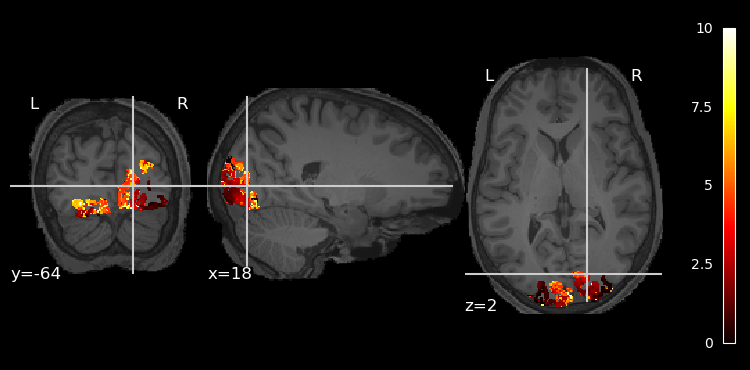

In [5]:
ecc_across_cortex = NSP.utils.cap_values(prf_dict['subj01']['nsd_dat']['eccentricity']['prf_ar'], 0, 10) * viscortex_mask.astype(bool)
NSP.analyse.plot_brain(prf_dict, roi_masks, 'subj01', ecc_across_cortex, False)

##### Define the pRF requirements

In [5]:
subject = 'subj01'
max_size = 1
min_size = .4
patchbound = 1.5
min_nsd_R2 = 25
min_prf_R2 = 0

##### Build a dictionary with VoxelSieve class instances for each region of interest containing voxels that fulfill these requirements.

In [43]:
subject = 'subj01'
max_size = 1000
min_size = 0
patchbound = 1000
min_nsd_R2 = 0
min_prf_R2 = 0

In [44]:
voxeldict = {}
for roi in rois:
    print_attr = True if roi == rois[len(rois)-1] else False
    voxeldict[roi] = VoxelSieve(NSP, prf_dict, roi_masks,
                                subject=subject, 
                                roi=roi, 
                                max_size=max_size, 
                                min_size=min_size, 
                                patchbound=patchbound, 
                                min_nsd_R2=min_nsd_R2, 
                                min_prf_R2=min_prf_R2,
                                print_attributes=print_attr)

V1 voxels that fulfill requirements: 7652 out of 7887.
V2 voxels that fulfill requirements: 8013 out of 8296.
V3 voxels that fulfill requirements: 6861 out of 7022.
V4 voxels that fulfill requirements: 3815 out of 3976.

Class contains the following attributes:
 .angle
 .ecc
 .nsd_R2
 .patchbound
 .prf_R2
 .sigmas
 .size
 .vox_pick
 .xcoor
 .xyz
 .ycoor


##### Visualise the pRFs

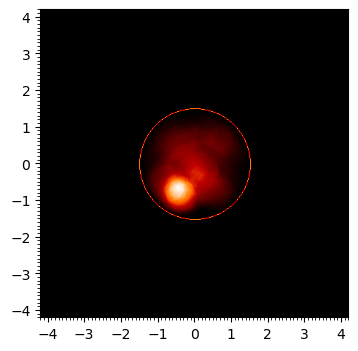

In [8]:
NSP.cortex.plot_prfs(voxeldict['V2'], enlarge=False, which_voxels='all', cmap='gist_heat')

##### Load in the HRF signal betas for the selected voxels

In [9]:
ydict = {}
for roi in rois:
    ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials='all').T
    print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')

V1 y-matrix has dimensions: (30000, 133)
V2 y-matrix has dimensions: (30000, 190)
V3 y-matrix has dimensions: (30000, 271)
V4 y-matrix has dimensions: (30000, 337)


##### Inspect some individual pRFs with corresponding parameter values

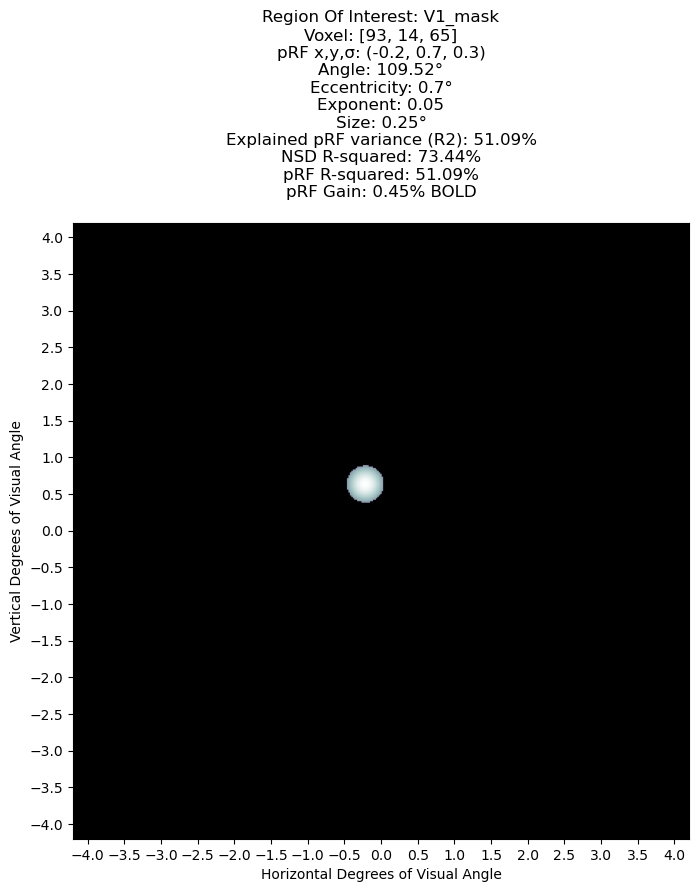

In [10]:
roi = 'V1'
randomvox = random.randint(0, voxeldict[roi].xyz.shape[0])
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        subject=subject,
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=voxeldict[roi].xyz[randomvox])

## Acquire the baseline visual contrast and estimated unpredictability values of the naturalistic images

##### Load in one of the baseline features (Root Mean Square, Spatial Coherence, Contrast Energy)

In [13]:
Xrms = NSP.stimuli.baseline_feats('rms')
Xce = NSP.stimuli.baseline_feats('ce')
Xsc = NSP.stimuli.baseline_feats('sc_l') # the _l attachment is for 'large' -> computed feature for 5° radius patch

Example of the Root Mean Square visual contrasts

(0.004392036447545011, 1.3856085413214227, 191.61227688284717, 1.0972071397608485)


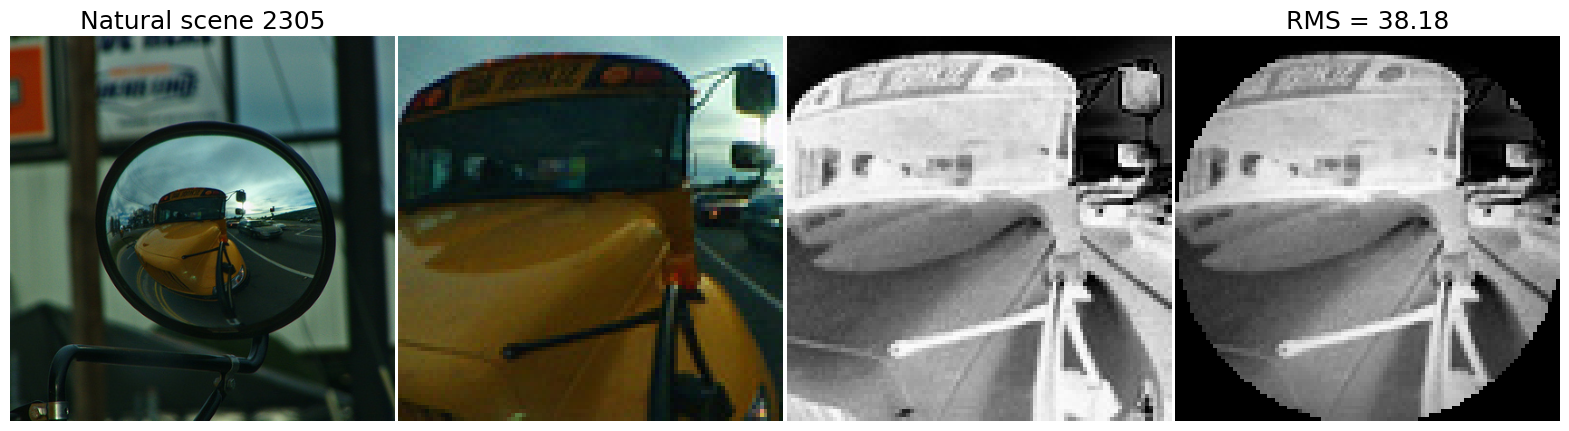

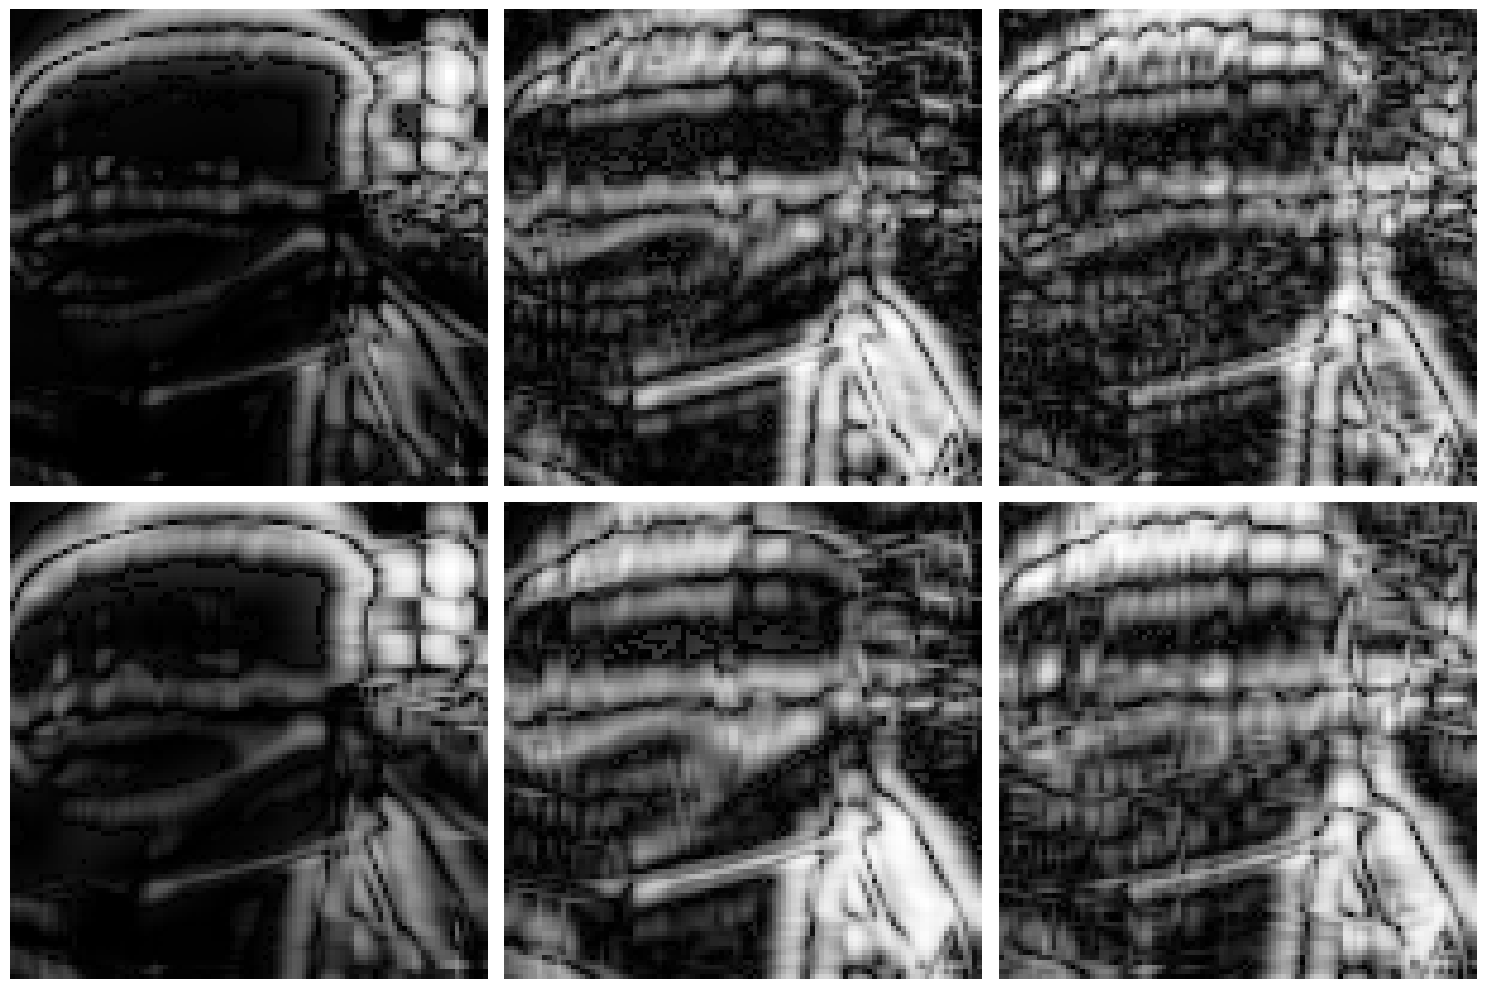

In [27]:
scene = random.randint(0,72999)
_ = NSP.stimuli.rms_single(args=(scene, 1, 1, False, True, 'center', True, False, False),
                       ecc_max=1,
                       cmap='Greys_r',
                       normalise=True,
                       lab_idx=0)

a = scce_single((scene, 0, 1, 'y', 'center', True, False, False), ecc_max = 1, cmap = 'Greys_r') # Crop prior
print(a)

### TODO: Implement this preview in NSP, and think about what makes sense to show. Quickly look up the computations for SC and CE in the LGN class, and add the OG img and crop to the current plot. MAke sure that it's clear what you're seeing in the plot. 

### But, don't put in too much effort because not at all crucial. Do make sure it's the same image as the one for RMS, helps make things clear

In [12]:
import yaml
import lgnpy.CEandSC.lgn_statistics
from lgnpy.CEandSC.lgn_statistics import lgn_statistics, loadmat, LGN

In [11]:
# Function that calculates rms but based on a RGB to LAB conversion, which follows the CIELAB colour space
# This aligns best with the way humans perceive visual input. 
def get_scce_contrast(rgb_image, mask_w_in, rf_mask_in, full_array, plot = 'n', cmap = 'gist_gray', 
                      crop_prior:bool = False, crop_post:bool = False, save_plot:bool = False):

    lgn_out = lgn_statistics(im=rgb_image, file_name='noname.tiff',
                                        config=config, force_recompute=True, cache=False,
                                        home_path='./notebooks/alien_nbs/', verbose = False, verbose_filename=False,
                                        threshold_lgn=threshold_lgn, compute_extra_statistics=False,
                                        crop_prior = True)
    
    ce = np.mean(lgn_out[0][:, :, 0])
    sc = np.mean(lgn_out[1][:, :, 0])
    beta = np.mean(lgn_out[2][:, :, 0])
    gamma = np.mean(lgn_out[3][:, :, 0])
    
    if plot == 'y':
        fig,axs = plt.subplots(2,3, figsize=(15,10))
        plt.subplots_adjust(wspace=.01, hspace=.01)
        axs[0,0].imshow(lgn_out[4]['par1'], cmap=cmap)
        axs[0,0].axis('off')
        axs[0,1].imshow(lgn_out[4]['par2'], cmap=cmap)
        axs[0,1].axis('off')
        axs[0,2].imshow(lgn_out[4]['par3'], cmap=cmap)
        axs[0,2].axis('off')
        axs[1,0].imshow(lgn_out[4]['mag1'], cmap=cmap)
        axs[1,0].axis('off')
        axs[1,1].imshow(lgn_out[4]['mag2'], cmap=cmap)
        axs[1,1].axis('off')
        axs[1,2].imshow(lgn_out[4]['mag3'], cmap=cmap)
        axs[1,2].axis('off')
        plt.tight_layout()

        if save_plot:
            fig.savefig(f'rms_crop_prior_{str(crop_prior)}_crop_post_{str(crop_post)}.png')
            
    return ce, sc, beta, gamma

def scce_single(args, ecc_max = 2.8, loc = 'center', plot = 'n', cmap = 'gist_gray'):
    i, start, n, plot, loc, crop_prior, crop_post, save_plot  = args
    dim = NSP.stimuli.show_stim(hide=True)[0].shape[0]
    radius = ecc_max * (dim / 8.4)
    
    if loc == 'center':
        x = y = (dim + 1)/2
    elif loc == 'irrelevant_patch':
        x = y = radius + 10
        
    mask_w_in = NSP.utils.css_gaussian_cut(dim, x, y, radius).reshape((425,425))
    rf_mask_in = NSP.utils.make_circle_mask(dim, x, y, radius, fill = 'y', margin_width = 0)
    full_ar_in = ar_in = NSP.stimuli.show_stim(img_no=i, hide=True)[0]  
    
    if i % 100 == 0:
        print(f"Processing image number: {i} out of {n + start}")
        
        
    # Crop the image first, then provide this as input to the visfeat function
    if crop_prior:
        
        x_min, x_max, y_min, y_max = NSP.utils.get_bounding_box(rf_mask_in)
        ar_in = ar_in[x_min:x_max, y_min:y_max]
        mask_w_in = mask_w_in[x_min:x_max, y_min:y_max]
        rf_mask_in = rf_mask_in[x_min:x_max, y_min:y_max]
        
    return get_scce_contrast(ar_in, mask_w_in, rf_mask_in, full_ar_in, plot = plot, cmap = cmap, 
                             crop_prior = crop_prior, crop_post = crop_post, save_plot = save_plot)

In [14]:
config_path = '/home/rfpred/notebooks/alien_nbs/lgnpy/lgnpy/CEandSC/default_config.yml'

with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.UnsafeLoader)

lgn = LGN(config=config, default_config_path=config_path)

threshold_lgn = loadmat(filepath='/home/rfpred/notebooks/alien_nbs/lgnpy/ThresholdLGN.mat')['ThresholdLGN']

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


Processing image number: 3900 out of 1
(0.000909343713159301, 1.5184467152101782, 179.00216884549073, 1.37579722109092)


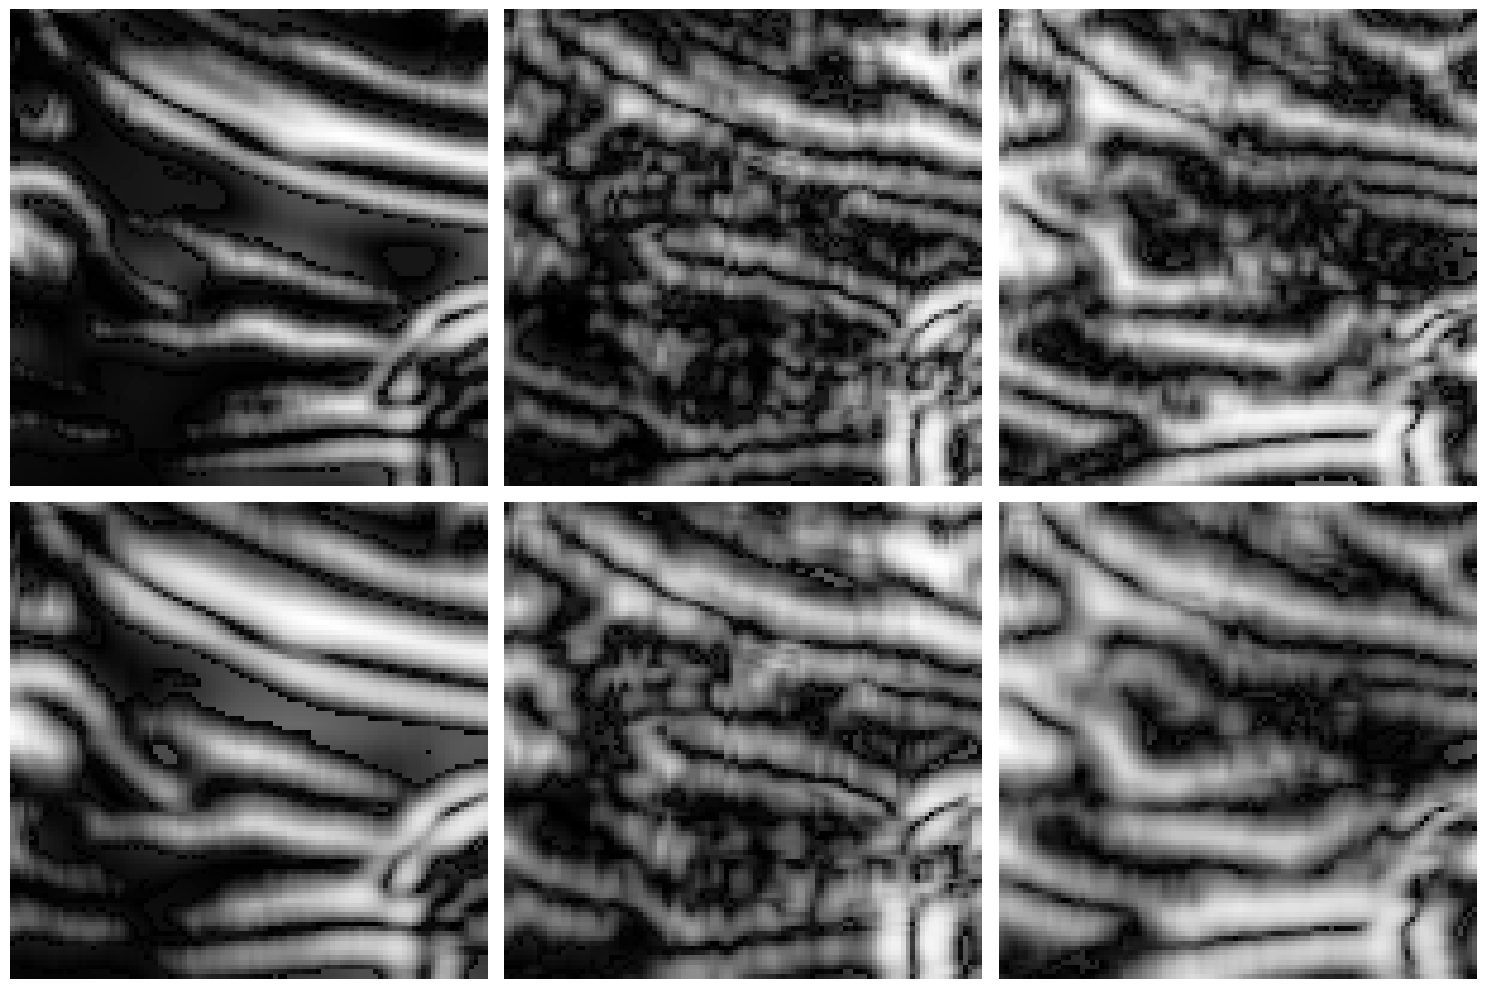

##### Load in a selection of the loss metrics from the U-Net, the Unpredictability features

In [28]:
Xpred = NSP.stimuli.unpred_feats(content=True, style=False, ssim=False, pixel_loss=False, L1=True, MSE=False, verbose=True)

['content_loss_0_L1', 'content_loss_0_MSE', 'content_loss_1_L1', 'content_loss_1_MSE', 'content_loss_2_L1', 'content_loss_2_MSE', 'content_loss_3_L1', 'content_loss_3_MSE', 'content_loss_4_L1', 'content_loss_4_MSE', 'ssim']


Loading the Model...
Running the inpainting file from /rfpred/src/inpainting.py


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time per image: 0.12835532426834106 seconds


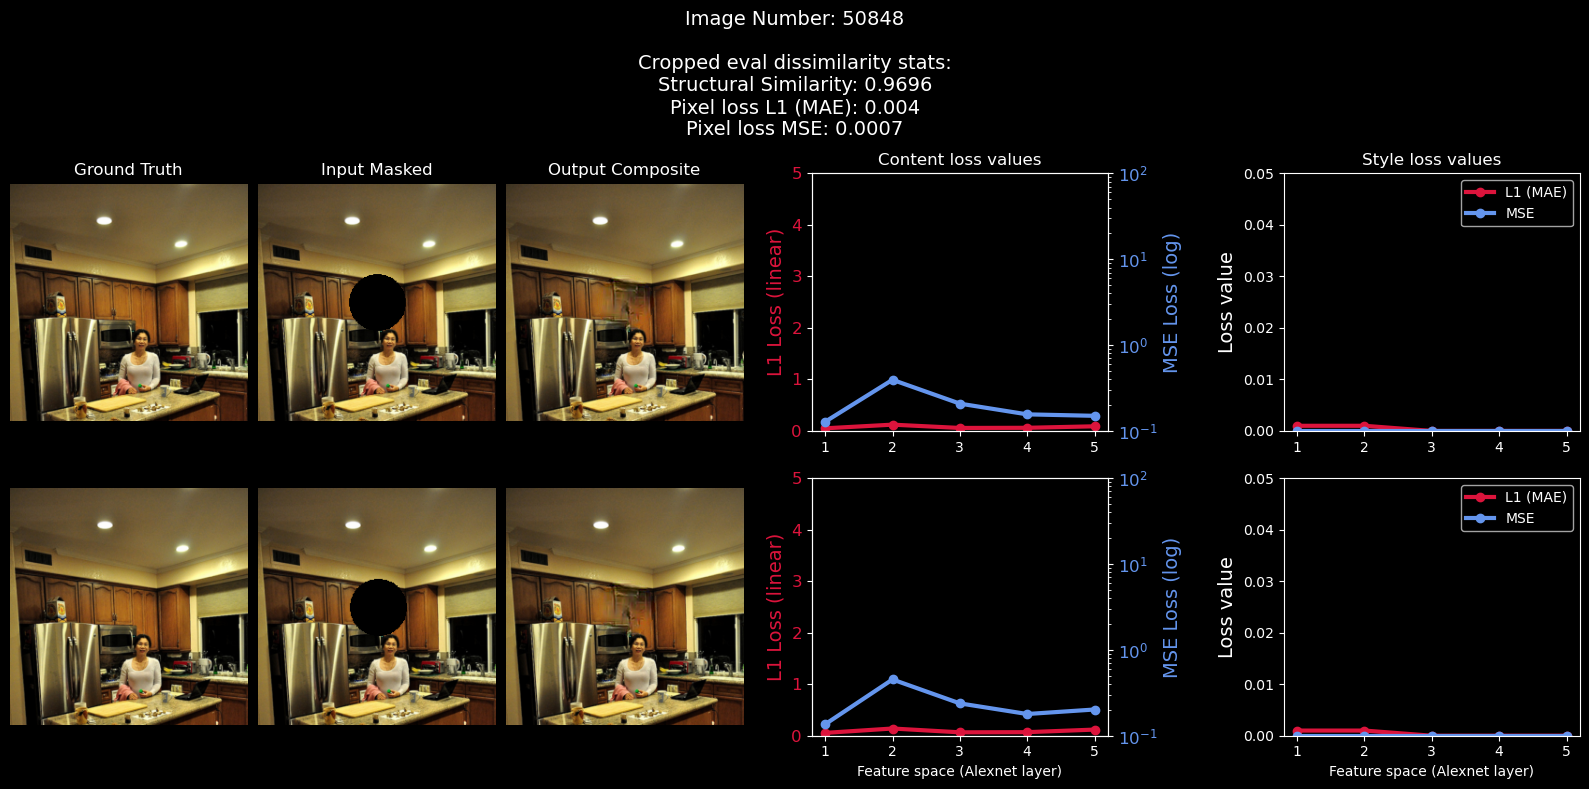

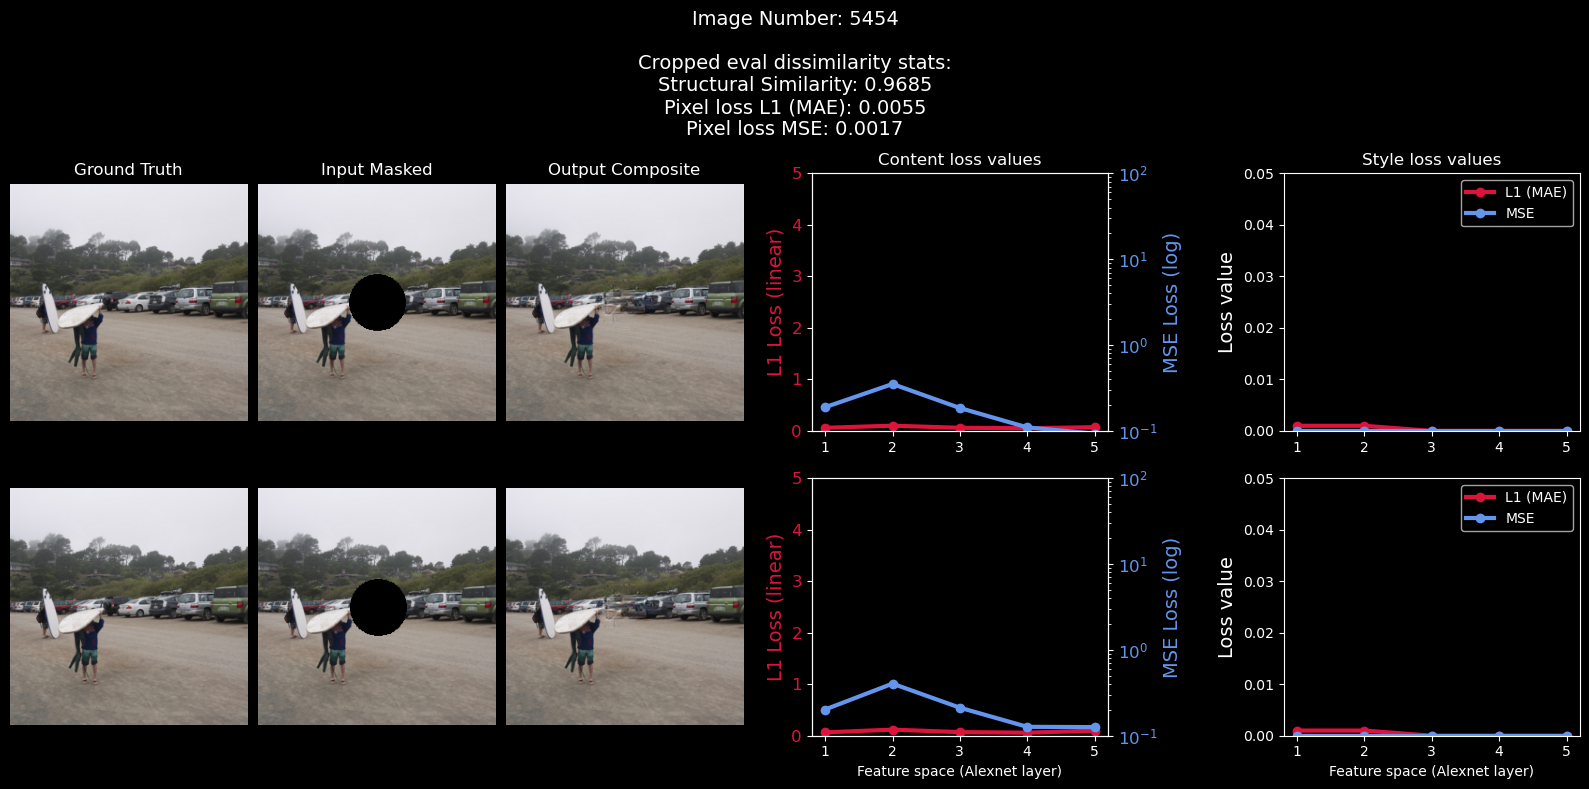

In [53]:
# WORKS! Now it would be nice to also check the images for a subject's specific design matrix
# eval_mask was 1.2

# Fix that it saves a 'feats_gt_np_n.pkl' file everytime it's ran
_ = NSP.stimuli.predplot(subject=subject, start_img=1, n_imgs=2, mask_loc='center', ecc_max=patchbound, 
               select_ices='random', cnn_type='alex', pretrain_version='places20k', 
               eval_mask_factor=np.sqrt(18), log_y_MSE='y')

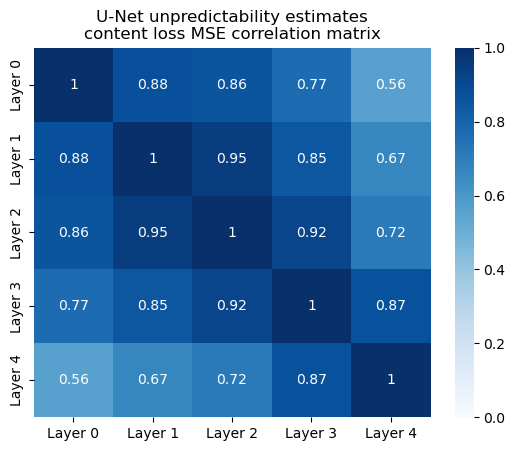

In [18]:
# Inspect the correlation matrix for a specific set of the loss metrics
NSP.stimuli.unpred_corrmatrix(type='content', loss_calc='MSE', cmap='Blues')

##### Plot a similar correlation matrix, but also add the baseline contrast features

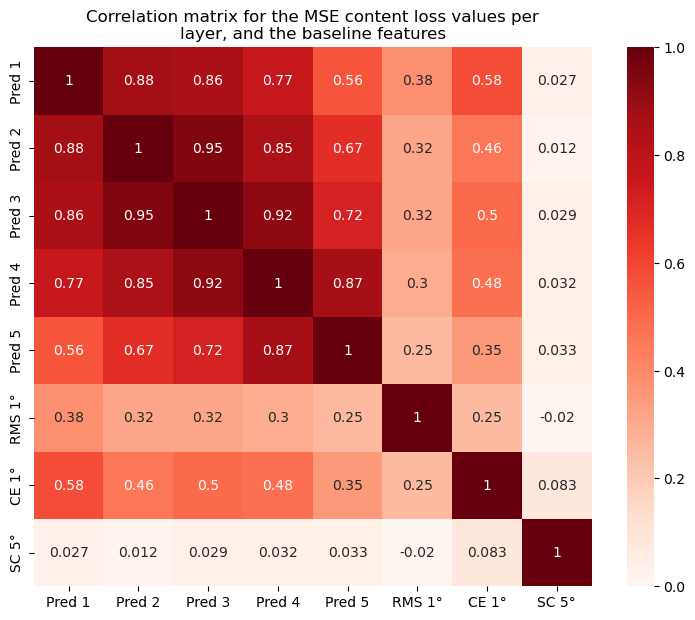

In [19]:
NSP.stimuli.plot_correlation_matrix(include_rms=True, include_ce=True, include_ce_l=False, include_sc=False, include_sc_l=True, cmap='Reds')

## Feature map extraction from AlexNets

##### Load in a selection of the AlexNet feature maps extracted from the adjusted U-Net class

In [25]:
Xalex_unet = NSP.stimuli.unet_featmaps(list_layers=[3], scale='full')

##### Inspect the feature maps extracted from UNet

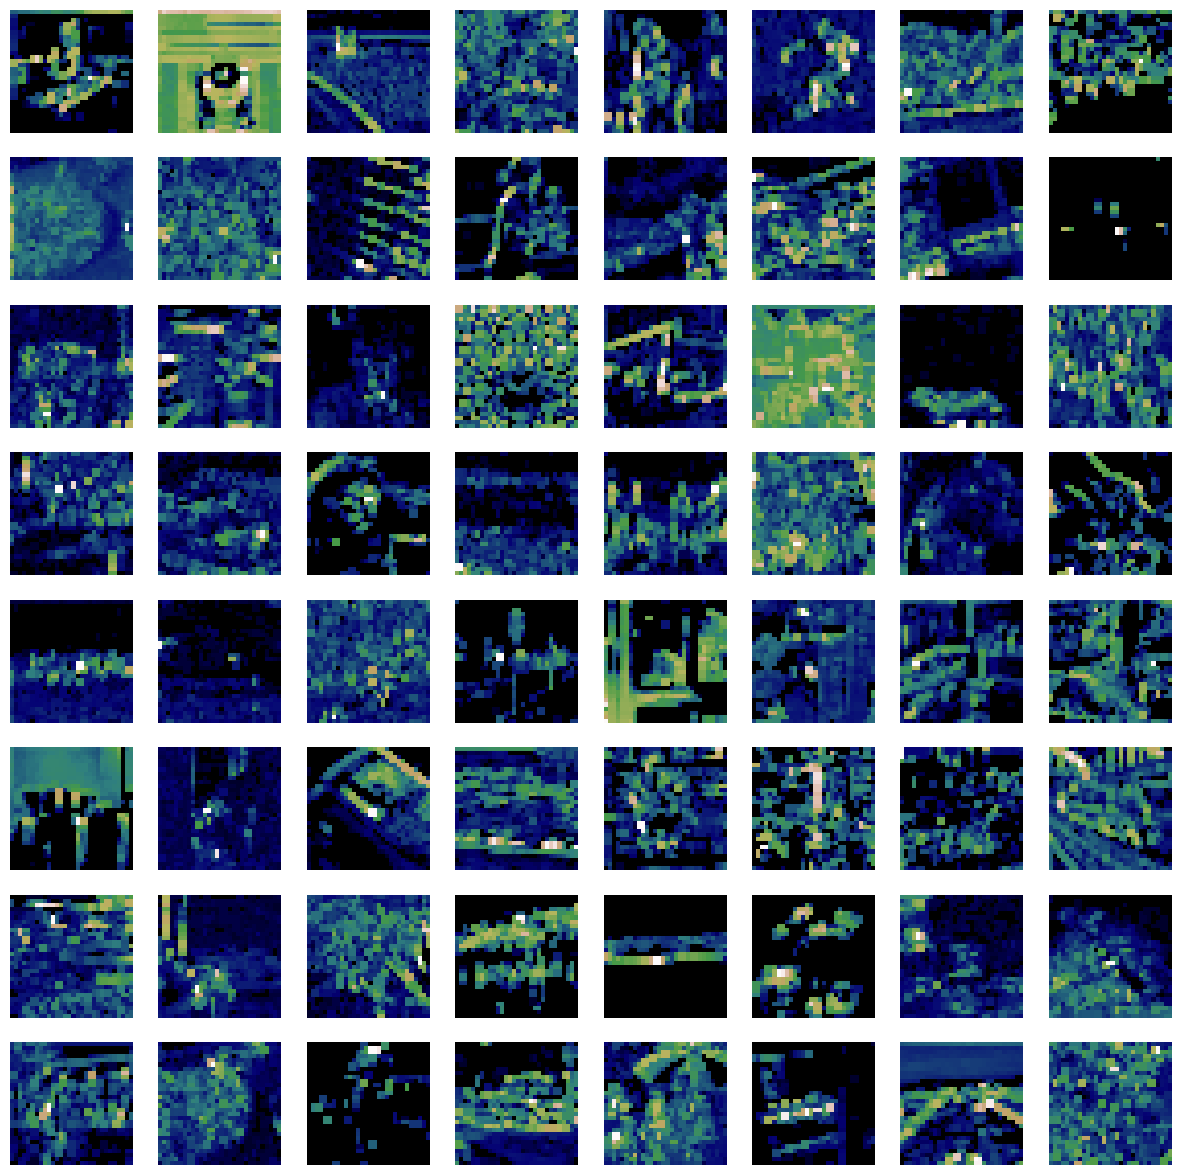

In [16]:
NSP.stimuli.plot_unet_feats(layer=0, batch=0, cmap='gist_earth', subject=subject, scale='full')

##### Extracted features from my own alexnet implementation

In [41]:
layer_nos = [4, 7, 9, 11] # Which layers to take the extracted feature maps from
Xalex_own = NSP.stimuli.alex_featmaps(layer_nos, pcs_per_layer='all', subject='subj01')

##### Some visual checks of these features

In [296]:
# Be aware that the layer number here is 1 more than the ones of the 'alex_layn.npy' files, because there I do not include the input layer
# so alex_lay0 corresponds with layer1 here.
img_ids, dataset, pca, feature, lay, layname = NSP.stimuli.extract_features(subject='subj01', layer=12,
                                                     start_img=8, n_imgs=2, batch_size=2, pca_components=2,
                                                     verbose=True, img_crop=True)

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['input', 'Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2', 'Conv2d_3', 'ReLU_3', 'Conv2d_4', 'ReLU_4', 'Conv2d_5', 'ReLU_5', 'MaxPool2d_3', 'Dropout_1', 'Linear_1', 'ReLU_6', 'Dropout_2', 'Linear_2', 'ReLU_7', 'Linear_3']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


  0%|          | 0/1 [00:00<?, ?it/s]

### Turn this into functions

In [43]:
# The ReLU layers of the alexnet are at layerfeatures 1, 4, 7, 9, and 11
# Here we stack all those for the ultimate regression, vary the top_n principal components of these layers
layer_nos = [1, 4, 7, 9, 11]
X_all = []
for layer in layer_nos:
    this_X = np.load(f'/home/rfpred/data/custom_files/subj01/center_strict/alex_lay{layer}.npy')[:,:500]
    if layer == 1:
        X_all = this_X
    else: X_all = np.hstack((X_all, this_X))
    
    
# Columns are the n amount of prinicple components multiplied by the amount of layers, so for example 100 * 5 = 500
print(X_all.shape)
X = X_all

(30000, 2500)


ReLU_5


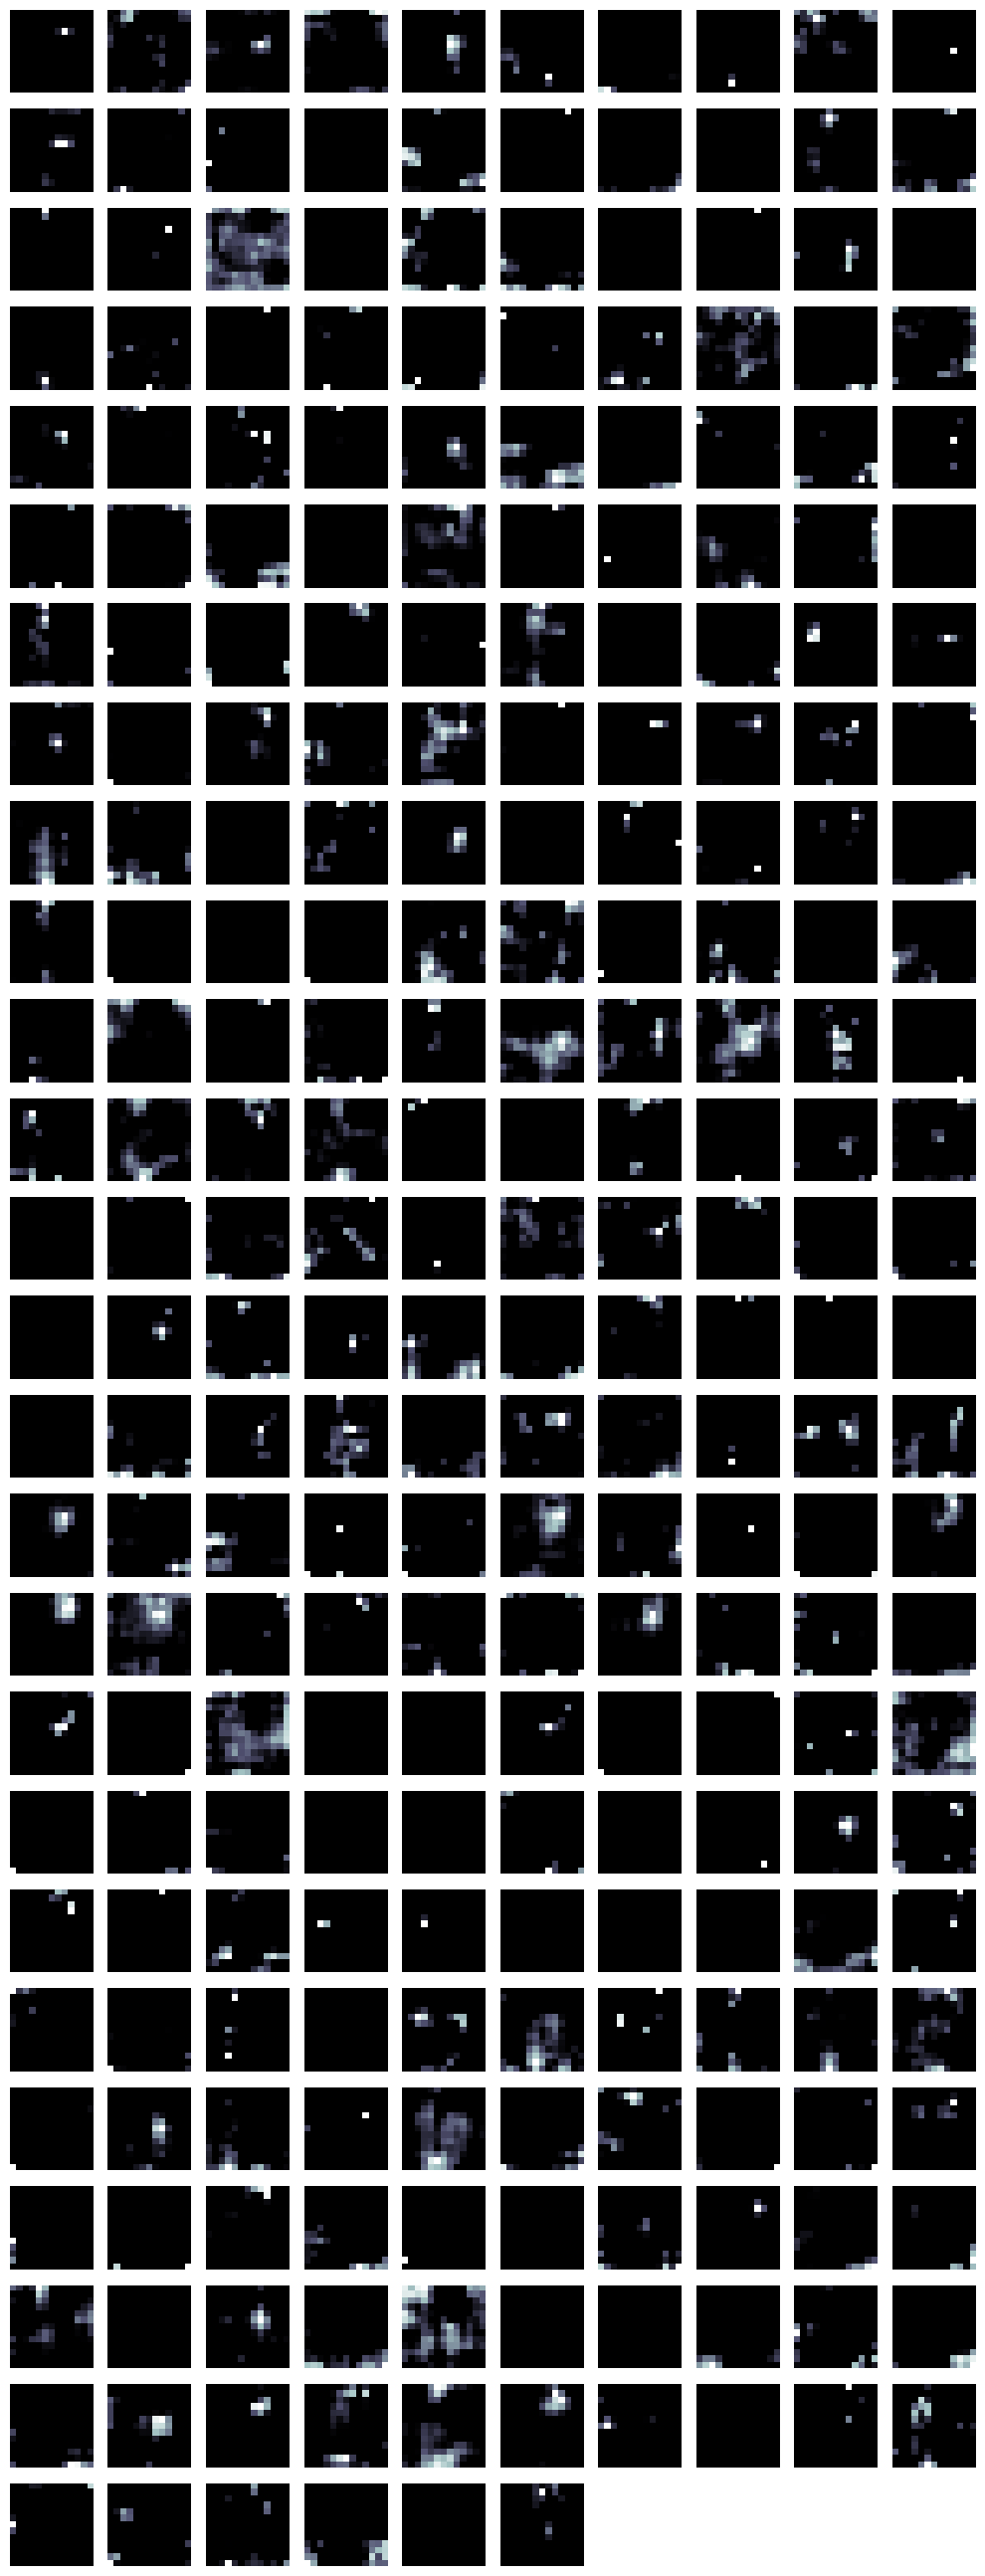

In [44]:
# Plot the feature maps
print(layname)
NSP.stimuli.plot_features(which_img=0, layer=lay, layer_type=layname, img_ids=img_ids, features=feature, num_cols=10, random_cmap=False)

[[1.      0.08214 0.00542 0.05842 0.05225]
 [0.08214 1.      0.00854 0.13029 0.11727]
 [0.00542 0.00854 1.      0.00852 0.00438]
 [0.05842 0.13029 0.00852 1.      0.13055]
 [0.05225 0.11727 0.00438 0.13055 1.     ]]


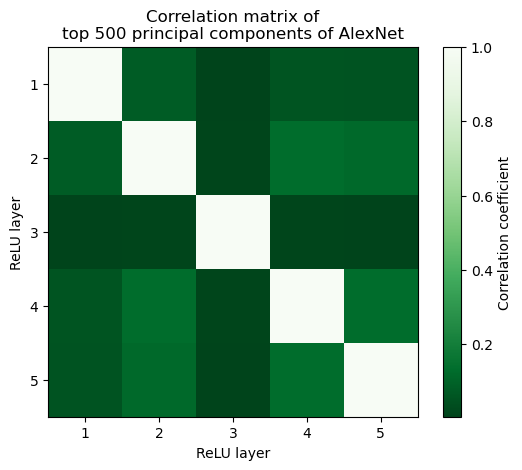

In [45]:
# Correlation matrix for the 5 AlexNet layers
# Split X_all into separate arrays for each layer
X_split = np.hsplit(X_all, len(layer_nos)) # Amazing function, splits the array into n arrays along the columns

# Initialize an empty matrix for the correlations
corr_matrix = np.empty((len(layer_nos), len(layer_nos)))

# Calculate the correlation between each pair of layers
for i in range(len(layer_nos)):
    for j in range(len(layer_nos)):
        corr_matrix[i, j] = np.corrcoef(X_split[i].flatten(), X_split[j].flatten())[0, 1]

print(corr_matrix)

# Create a heatmap from the correlation matrix
plt.imshow(corr_matrix, cmap='Greens_r', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')

relu_nos = [no for no in range(1,6)]
# Set the tick labels
plt.xticks(np.arange(len(layer_nos)), relu_nos)
plt.yticks(np.arange(len(layer_nos)), relu_nos)

# Set the title and labels
plt.title('Correlation matrix of\ntop 500 principal components of AlexNet')
plt.xlabel('ReLU layer')
plt.ylabel('ReLU layer')

plt.show()

##### Regression template, integrate

In [33]:

def plot_scores(ydict, X, alpha, cv, rois, X_uninformative, fit_icept:bool=False, save_outs:bool=False) -> np.ndarray:
    r_values = {}
    r_uninformative = {}
    cor_scores_dict = {}  # Dictionary to store cor_scores

    # Calculate scores for the given X
    for roi in rois:
        y = ydict[roi]
        model = NSP.analyse.run_ridge_regression(X, y, alpha=alpha, fit_icept=False)
        _, cor_scores = NSP.analyse.score_model(X, y, model, cv=cv)
        r_values[roi] = np.mean(cor_scores, axis=0)
        cor_scores_dict[roi] = cor_scores  # Save cor_scores to dictionary

        xyz = voxeldict[roi].xyz
        this_coords = np.hstack((xyz, np.array(r_values[roi]).reshape(-1,1)))
        if roi == 'V1':
            coords = this_coords
        else:
            coords = np.vstack((coords, this_coords))

    # Calculate scores for the uninformative X
    for roi in rois:
        y = ydict[roi]
        model = NSP.analyse.run_ridge_regression(X_uninformative, y, alpha=alpha, fit_icept=fit_icept)
        _, cor_scores = NSP.analyse.score_model(X_uninformative, y, model, cv=cv)
        r_uninformative[roi] = np.mean(cor_scores, axis=0)

    # Create a figure with 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Assuming rois is a list with at least 4 elements
    for i, roi in enumerate(rois[:4]):
        # Underlay with the histogram of r_uninformative[roi] values
        axs[i].hist(r_uninformative[roi], bins=40, edgecolor='black', alpha=0.5, label='Uninformative X')
        # Plot the histogram of r_values[roi] values in the i-th subplot
        axs[i].hist(r_values[roi], bins=40, edgecolor='black', alpha=0.5, label='X')
        axs[i].set_title(f'R values for {roi}')
        axs[i].legend()

    # Display the figure
    plt.tight_layout()
    plt.show()
    
    if save_outs:
        plt.savefig('HEREplot.png')  # Save the plot to a file
        # Save cor_scores to a file
        with open('HEREcor_scores.pkl', 'wb') as f:
            pickle.dump(cor_scores_dict, f)

    return coords

In [48]:
with open ('/home/rfpred/HEREcor_scores.pkl', 'rb') as f:
    cor_scores_dict = pickle.load(f)
    
# containers: cor_scores_dict[roi][cnn_layer][array of scores for each voxel]
print(cor_scores_dict['V1'][4])

for layer in range(0,5):
    print(layer)
    for roi in rois:
        
        if roi == 'V1':
            cor_coords = np.hstack((voxeldict[roi].xyz, np.array(cor_scores_dict[roi][0]).reshape(-1,1)))

    voxeldict['V1'].xyz


[0.46984 0.4298  0.48309 ... 0.28182 0.21046 0.25024]
0
1
2
3


In [29]:

X = NSP.stimuli.unet_featmaps([1])  # Get alexfet features
print(X.shape)
NSP.utils.inspect_dat(X)

(30000, 768)
Lowest value: -13.667881188811231
Highest value: 39.62655236534532
Mean value: -9.68361193700831e-20
Standard deviation: 1.0


In [85]:
# layer_nos = [4, 7] # Which layers to take the extracted feature maps from
# Xalexown = NSP.stimuli.alex_featmaps(layer_nos, pcs_per_layer='all', subject=subject)
Xbl = np.hstack((Xce, Xsc, Xrms, Xpred))

Klopt geen hoer van

In [38]:
print(X.shape)
print(ydict['V1'].shape)

(30000, 5)
(30000, 174)
(30000, 5)


In [30]:
# X = NSP.stimuli.unet_featmaps([2], scale='cropped')  # Get alexfet features
print(X.shape)

# layer_nos = [4] # Which layers to take the extracted feature maps from
# X = NSP.stimuli.alex_featmaps(layer_nos, pcs_per_layer='all', subject=subject)
# X = Xbl
# Xpred = NSP.stimuli.unpred_feats(content=True, style=False, ssim=False, pixel_loss=False, L1=True, MSE=False, verbose=True)
X = NSP.stimuli.baseline_feats('ce')

# X_uninformative = np.ones((Xrms.shape))
X_shuf = np.copy(X)
np.random.shuffle(X_shuf)



(30000, 768)


In [31]:
obj = plot_scores(ydict, X, alpha=10, cv=5, rois=rois, X_uninformative=X_shuf, fit_icept=False)

NameError: name 'plot_scores' is not defined

In [23]:
# Load ins
print(voxeldict['V1'].attributes)
y = ydict['V1'] # Get the HRF betas for the specified voxel requirements and use as y-matrix

# X = NSP.stimuli.unet_featmaps([2, 3]) # Get alexfet features

# layer_nos = [4, 7, 9, 11] # Which layers to take the extracted feature maps from
# Xalex_own = NSP.stimuli.alex_featmaps(layer_nos, pcs_per_layer='all', subject='subj01')

# X = Xpred # This one is not z-scored I see

X = np.ones((Xrms.shape))
# X = Xce

print(y.shape, X.shape)

['angle', 'ecc', 'nsd_R2', 'patchbound', 'prf_R2', 'sigmas', 'size', 'vox_pick', 'xcoor', 'xyz', 'ycoor']
(30000, 92) (30000, 1)


In [24]:
# Fit a ridge regression model to the data
model = NSP.analyse.run_ridge_regression(X, y, alpha=100)

In [25]:
# Get the resulting beta coefficients for every voxel
betas = model.coef_

In [26]:
y_hats, cor_scores = NSP.analyse.score_model(X, y, model, cv=5)

[ 0.03756  0.0429   0.02589  0.10515  0.03392 -0.01176  0.03264  0.00033
  0.03633 -0.0103  -0.00801  0.01637 -0.00312  0.09673 -0.00451  0.19532
  0.19414  0.03875  0.02269  0.05873  0.09576  0.15453  0.12171  0.04736
  0.02426  0.0408   0.09098  0.0384   0.01792  0.01347  0.00079  0.02757
  0.00355  0.06584  0.02167  0.06915  0.26264  0.06043  0.14146  0.10541
  0.24449  0.01047 -0.00152  0.63046  1.24257  0.13689  0.34908  0.00276
  0.10229  0.18698  1.40212  0.13188  1.2273   0.88551  0.13417  0.02665
  0.00961  0.00986  0.08366  0.05443  2.98769 -0.00022  1.59044  0.0728
  0.07424  0.01353  5.6079   0.02838  0.01542  0.00816  1.69399  0.14448
  0.02519  0.00139  0.00763  2.18988  0.00798  0.04678  0.00045  0.12241
  0.0072   0.06883  0.02151  0.14969  0.06375  0.1318   0.12079  0.04705
  0.01727  0.05031  0.05873  0.00892]


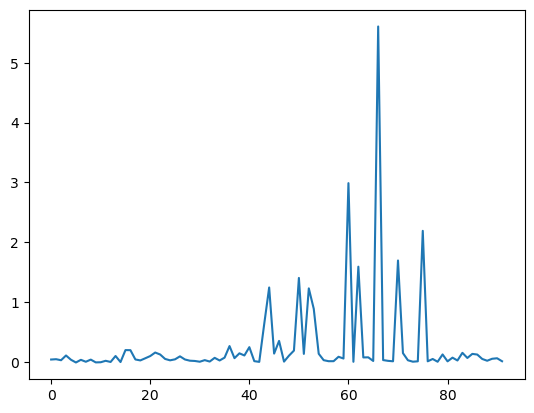

In [27]:
_=plt.plot((np.mean(cor_scores, axis=0))) # THis is averaged r values across folds for every voxel.
print(np.mean(cor_scores, axis=0))

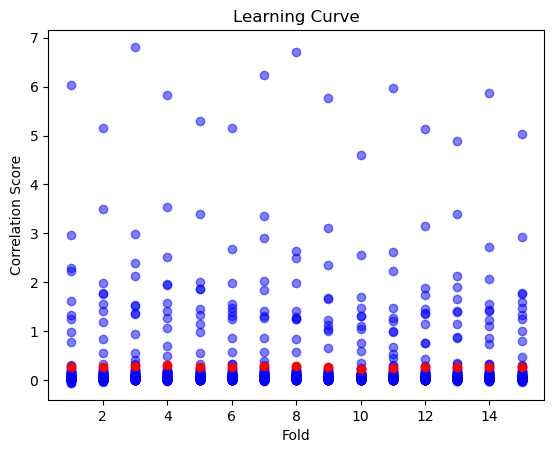

In [268]:
# plt.hist(cor_scores[10]) # So these are the values that indicate the extent to which the y and y_hat correlate.

vox = 19
fold=19
# plt.scatter(y[:,vox], y_hats[:,vox])
# print((cor_scores[fold][vox]))

# print(y.shape)
# print(y_hats.shape)

NSP.analyse.plot_learning_curve(X, y, model, 1, 15)

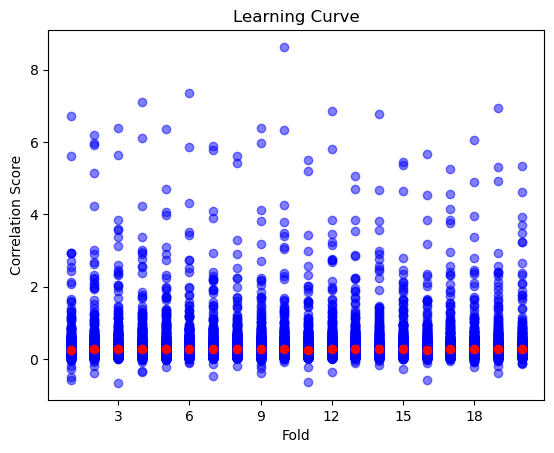

In [121]:
# y, xyzs = NSP.analyse.load_y('subj01', 'V1', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 100, start_img = 0, n_imgs = 3750, across_rois=True)
# y = NSP.datafetch._stack_betas('subj01', 'V2', True, 40)[:,3:].T
y = V1yselect.T
# plt.plot(y)
Xrms = NSP.stimuli.baseline_feats('rms')
# Xce = NSP.stimuli.baseline_feats('ce')
# Xsc_l = NSP.stimuli.baseline_feats('sc_l')
Xalex_unet = NSP.stimuli.unet_featmaps([3])

# X = np.ones((Xce.shape))
# X = NSP.stimuli.baseline_feats('ce_l')
X = Xalex_unet
model = NSP.analyse.run_ridge_regression(X, y, alpha=1)
betas = model.coef_ # This returns a beta coefficient for every voxel
# y_hats, cor_scores = NSP.analyse.score_model(Xpred, y, model, cv=5)
NSP.analyse.plot_learning_curve(X, y, model, 1, 20)


# cor_scores is a list with the voxel correlation scores for each cross-validation fold

### Do'nt forget to scale the betas, z00000scoror

In [105]:
y.shape

(30000, 8296)

#### Also check for irrelevant RMS values, beacuse it seems now as if anything yields nice results. Adapt the NSP.features.baseline thign to also 
#### include the irrelevant rms vlues.

In [97]:
# Took 2m 48s
for roi in rois:
    Xrms = NSP.stimuli.baseline_feats('rms')
    X = X_all
    betas = NSP.datafetch._stack_betas('subj01', roi, True, 40)
    y = betas[:,3:].T
    model = NSP.analyse.run_ridge_regression(X, y, alpha=.01)


    xyztest =(betas[:, :3])
             
    y_hats, cor_scores = NSP.analyse.score_model(X, y, model, cv=20)

    cor_means = np.mean(np.array(cor_scores), axis=0)
    if roi == 'V1':
        xyztest_stack = xyztest
        cor_means_stack = cor_means
    else: 
        xyztest_stack = np.vstack((xyztest_stack, xyztest))         
        cor_means_stack = np.hstack((cor_means_stack, cor_means))

brainresults = np.hstack((xyztest_stack, cor_means_stack.reshape(-1,1)))
np.save(f'/home/rfpred/data/custom_files/{subject}/brainstats/ce_viscortex.npy', brainresults)

NSP.analyse.plot_learning_curve(X, y, model, 1.0, 20)

# NSP.analyse.stat_on_brain(prf_dict, roi_masks, 'subj01', cor_means, xyzs, True)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

NameError: name 'cv' is not defined

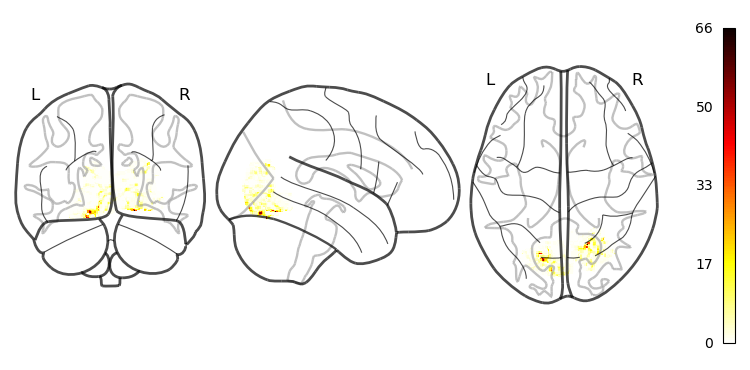

In [16]:
NSP.analyse.stat_on_brain(prf_dict, roi_masks, 'subj01', cor_means_stack, xyztest_stack, True)
# Xpred_results_brain = NSP.utils.coords2numpy(Xpred_results, roi_masks['subj01']['V1_mask'].shape, keep_vals=True)
# NSP.analyse.plot_brain(prf_dict, roi_masks, 'subj01', Xpred_results_brain, True)

Lowest value: -0.1852293430558951
Highest value: 63.48897093496528
Mean value: 0.44784907224832127
Standard deviation: 1.6281024405129818
There are 36 of these voxels


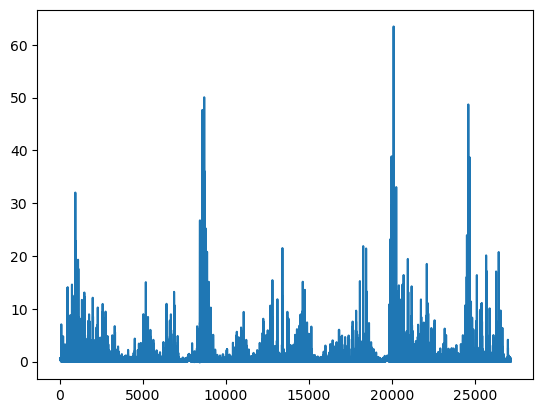

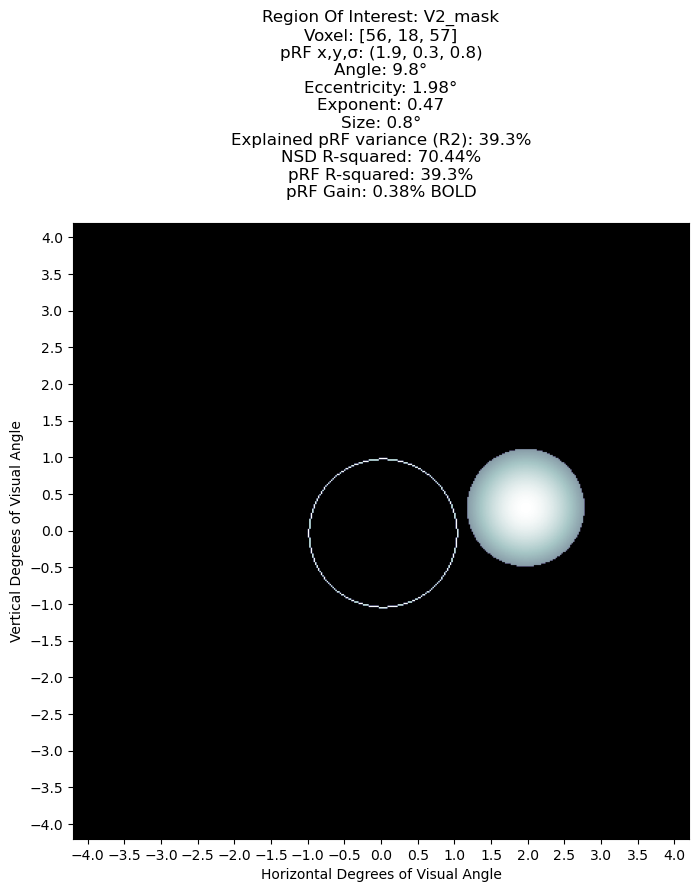

In [98]:
# DEfinitely turn this into a function, also couple with the heatmap stuff (ONCE MADE EFFICIENT). 
# Based on the highest correlation values resulting from the ridge reg, I can then plot the voxels that yield
# THe highest correlation values between y and yhat, as a sort of 'decoding validation'. Potentially very cool as an
# extra check to validate that certain visual features explain the activity best of the voxels with their pRFs inside the
# patch for which we calculated it. 
NSP.utils.inspect_dat(cor_means_stack)
plt.plot(cor_means_stack)
ices = cor_means_stack > 20
goodxyzs = xyztest_stack[ices]
print(f'There are {goodxyzs.shape[0]} of these voxels')

which_voxel = random.randint(0, goodxyzs.shape[0])
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        add_central_patch=True,
                        subject='subj01',
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=tuple(goodxyzs[which_voxel].astype(int)))

Lowest value: -0.2281478432195704
Highest value: 64.54057606785801
Mean value: 0.4493600181176349
Standard deviation: 1.6362796812565403
There are 132 of these voxels


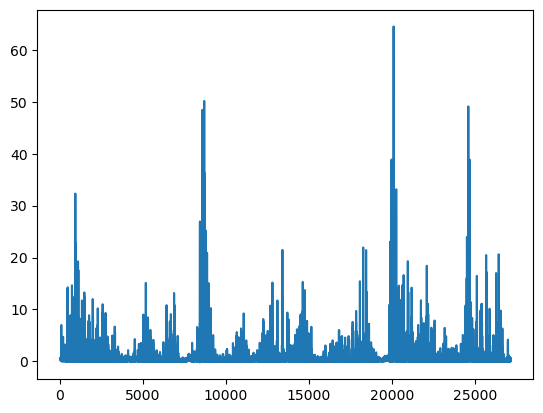

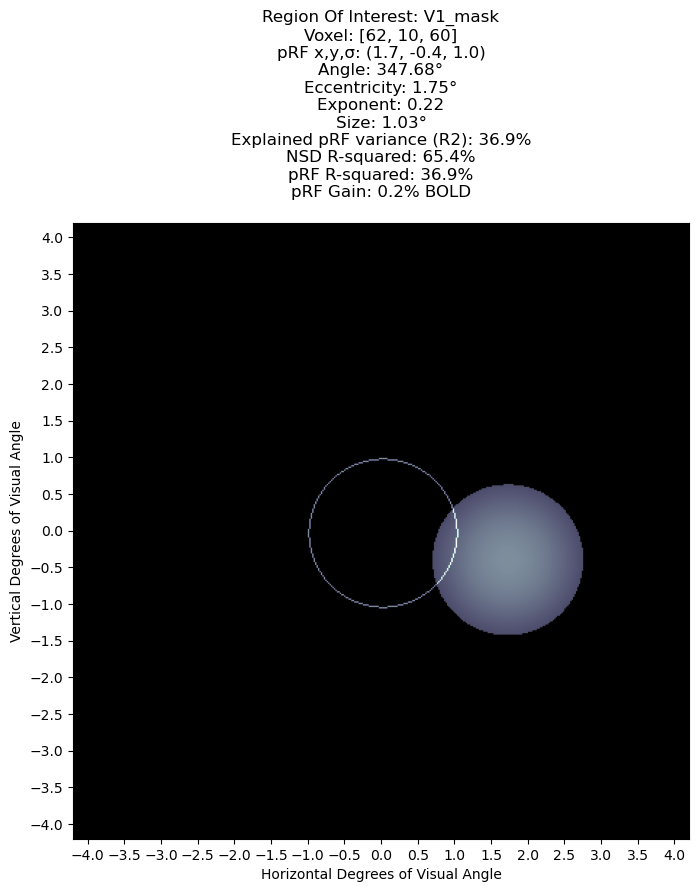

In [76]:
# DEfinitely turn this into a function, also couple with the heatmap stuff (ONCE MADE EFFICIENT). 
# Based on the highest correlation values resulting from the ridge reg, I can then plot the voxels that yield
# THe highest correlation values between y and yhat, as a sort of 'decoding validation'. Potentially very cool as an
# extra check to validate that certain visual features explain the activity best of the voxels with their pRFs inside the
# patch for which we calculated it. 
NSP.utils.inspect_dat(cor_means_stack)
plt.plot(cor_means_stack)
ices = cor_means_stack > 10
goodxyzs = xyztest_stack[ices]
print(f'There are {goodxyzs.shape[0]} of these voxels')

which_voxel = random.randint(0, goodxyzs.shape[0]-1)
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        add_central_patch=True,
                        subject='subj01',
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=tuple(goodxyzs[which_voxel].astype(int)))

In [37]:
y, xyzs = NSP.analyse.load_y('subj01', 'V2', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 'all', start_img = 0, n_imgs = 30000)

n_imgs = 100
X = Xce
alf = .01
cv = 15
results = NSP.analyse.evaluate_model(X[:n_imgs,:], y[:n_imgs], alpha=alf, cv=cv)

# Create a new numpy array with 4 columns
data = np.zeros((len(xyzs[:,0]), 4))

# Fill the first 3 columns with the xyz values
for i, coord in enumerate(xyzs[:,0]):
    data[i, :3] = coord

# Fill the fourth column with the cross-validation scores
data[:, 3] = results['cross_validation_scores']

NSP.analyse.plot_learning_curve(X[:n_imgs,:], y[:n_imgs], model=results['model'], alpha=alf, cv=cv)
results

print(data)

Loaded y-matrix with 165 voxels from ['V2']


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

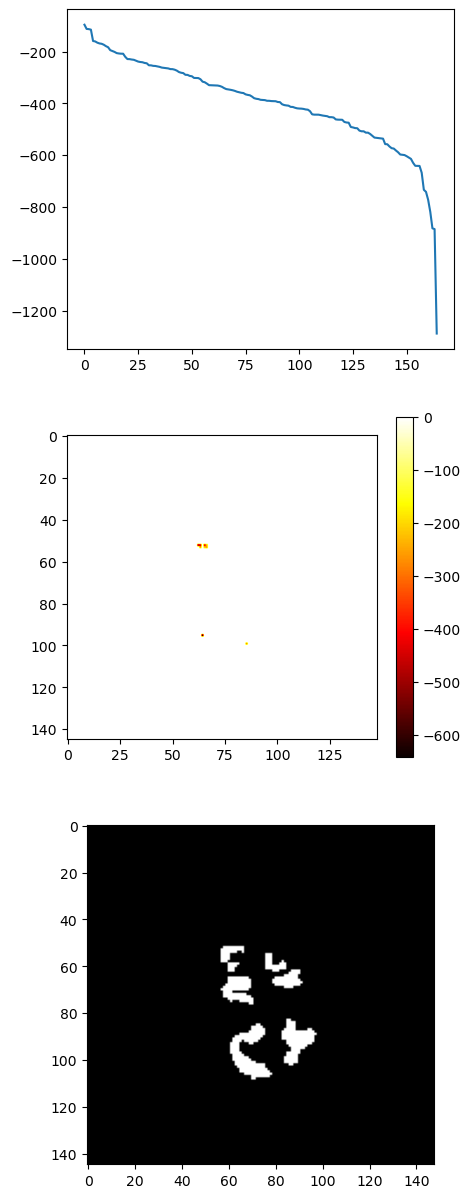

In [268]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define a diverging colormap where the 0 value is black
# colors = ["blue", "white", "red"]
# cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
# n_voxels = y_all.shape[1]
n_voxels = y.shape[1]

cv_r2_all = np.zeros((n_voxels, 4))
# for vox in range(len(results['cross_validation_scores'])):
for vox in range(n_voxels):
    for idx in range(3):
        # cv_r2_all[vox,idx] = xyzs_all[vox][0][idx]
        cv_r2_all[vox,idx] = xyzs[vox][0][idx]
    cv_r2_all[vox,3] = results['cross_validation_scores'][vox]




brain = NSP.utils.coords2numpy(cv_r2_all, shape=roi_masks['subj01']['V1_mask'].shape, keep_vals=True)

fig,axes = plt.subplots(3,figsize=(5,15))


cv_sorted = NSP.utils.sort_by_column(cv_r2_all, 3, top_n=n_voxels)
axes[0].plot(cv_sorted[:,3]*100)#[:,3].flatten

# Normalize the data to the range [-0.1, 0.1]
# norm = mcolors.Normalize(vmin=-0.002, vmax=0.002)

# Display the image with the custom colormap and normalization
im = axes[1].imshow(brain[:,16,:]*100, cmap='hot')
axes[2].imshow(roi_masks['subj01']['V2_mask'][:,16,:], cmap='gray')
# Add a colorbar
plt.colorbar(im)

plt.show()


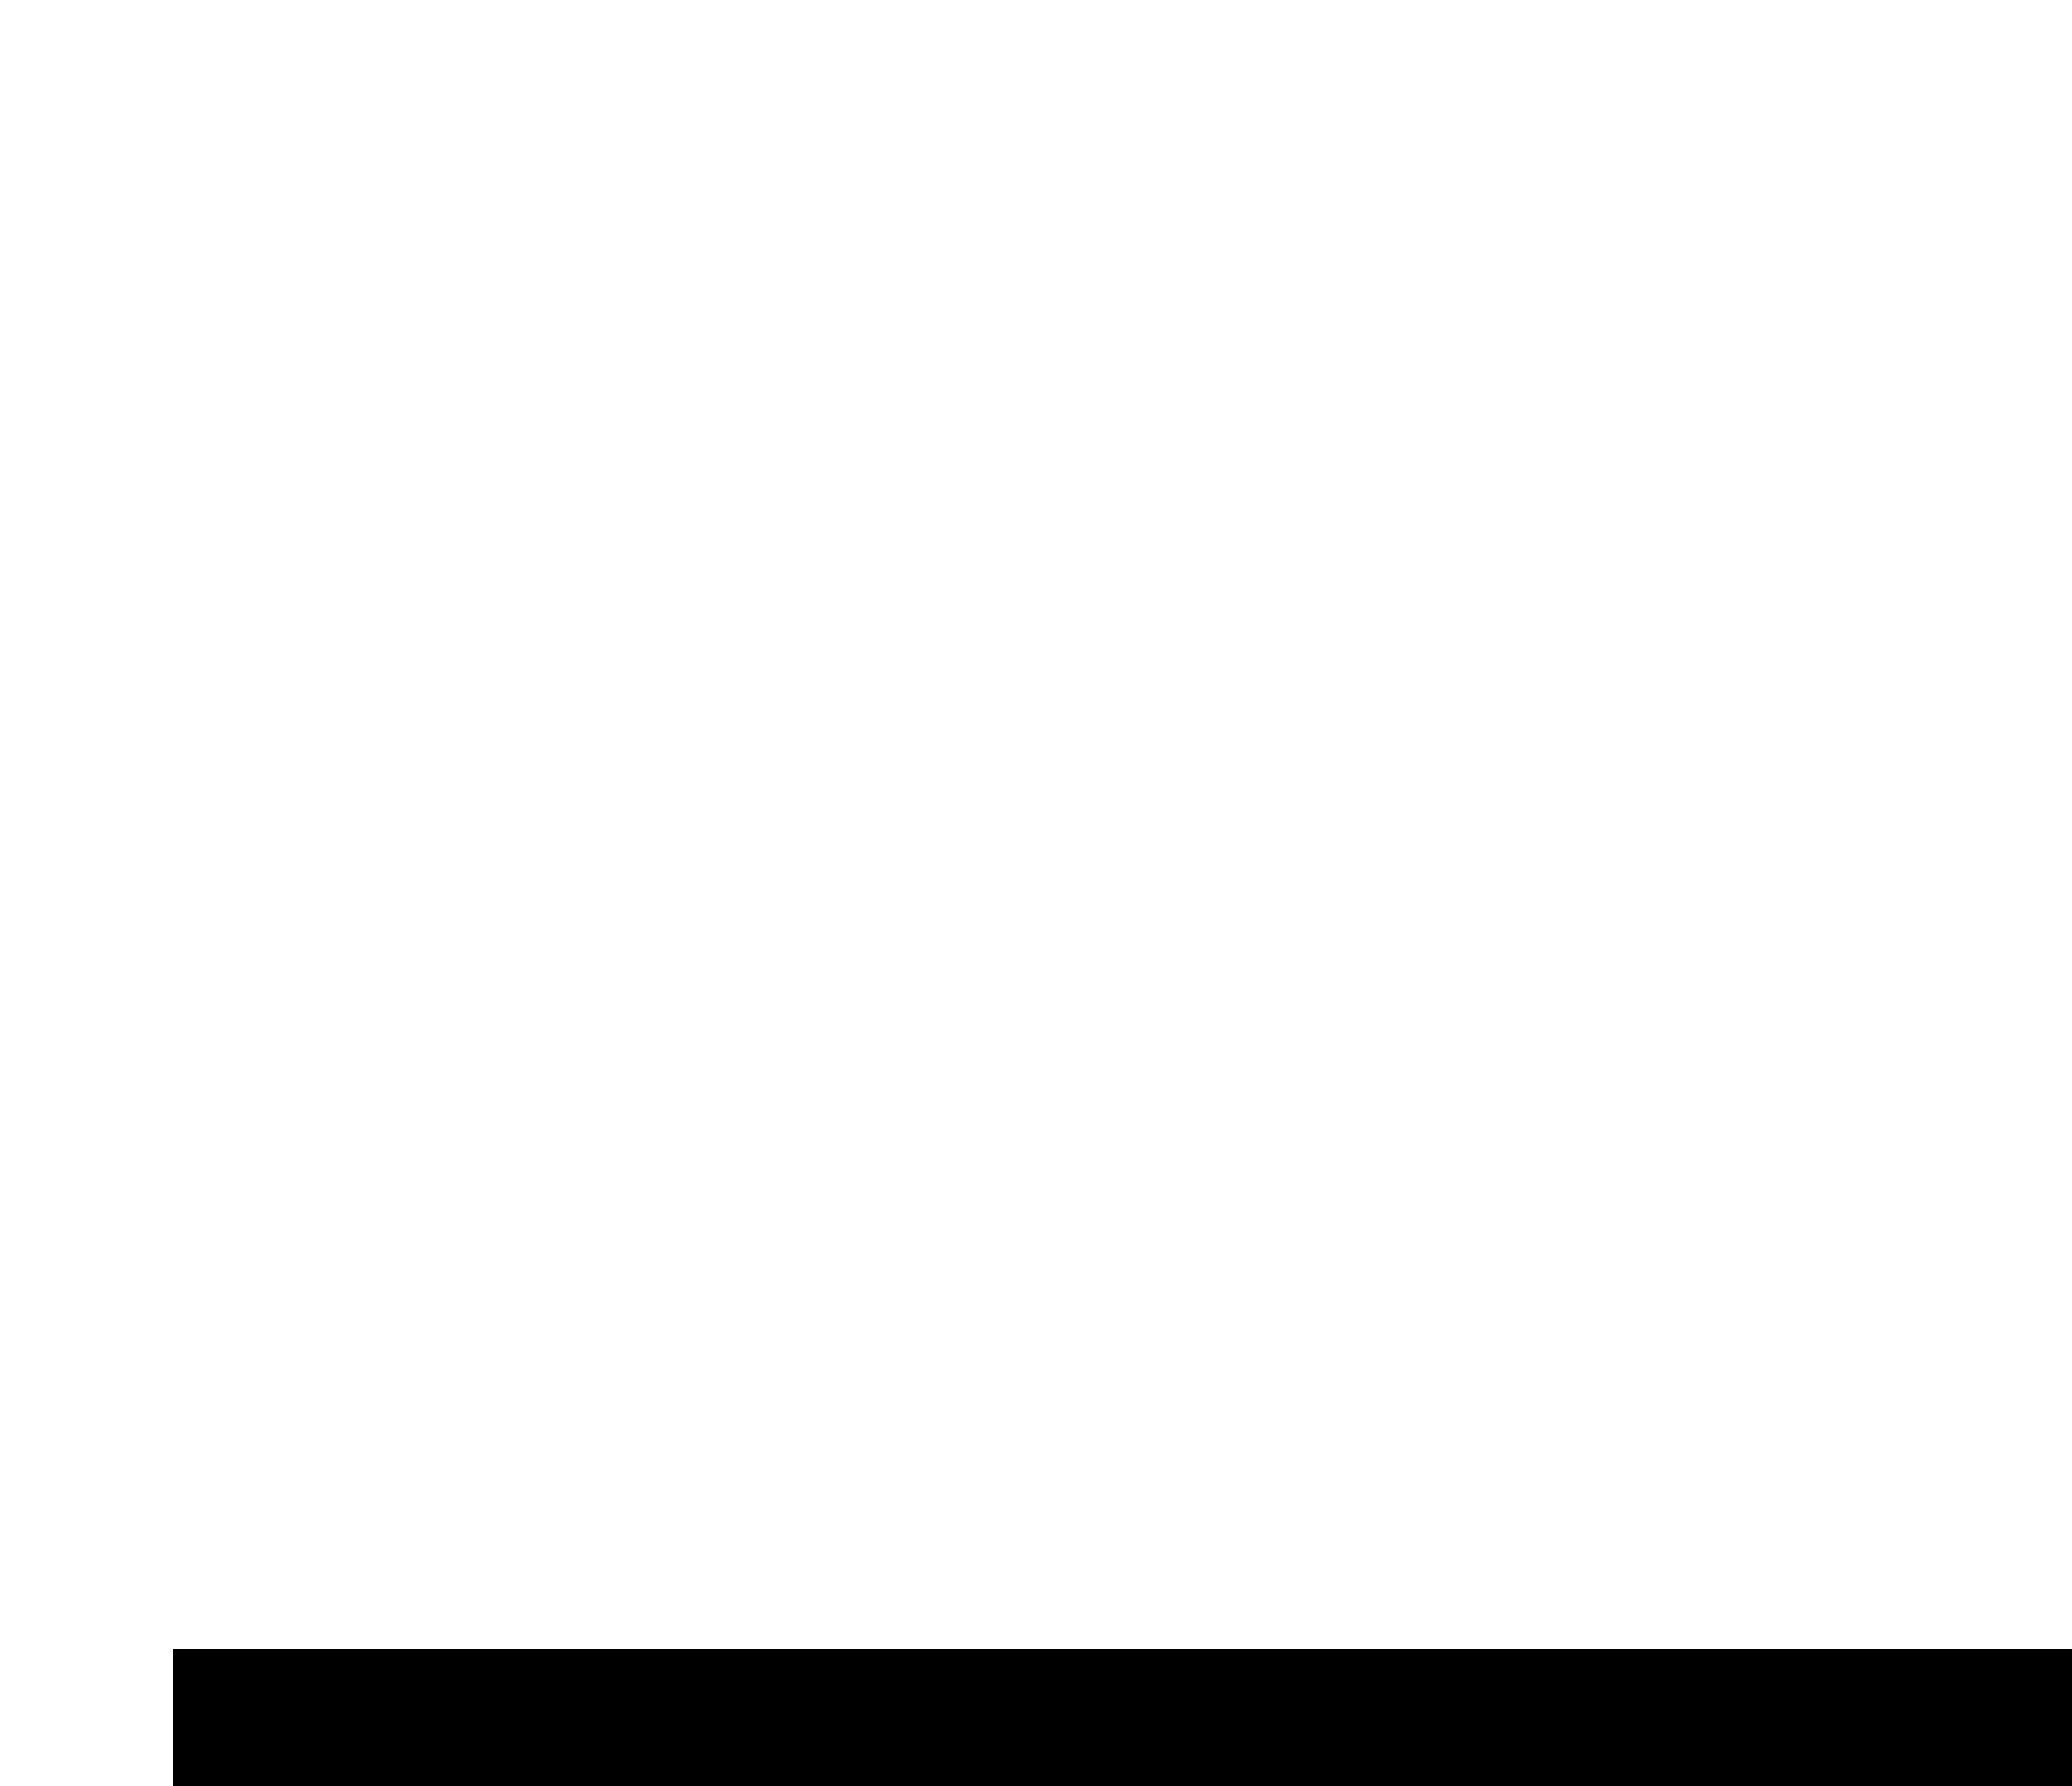
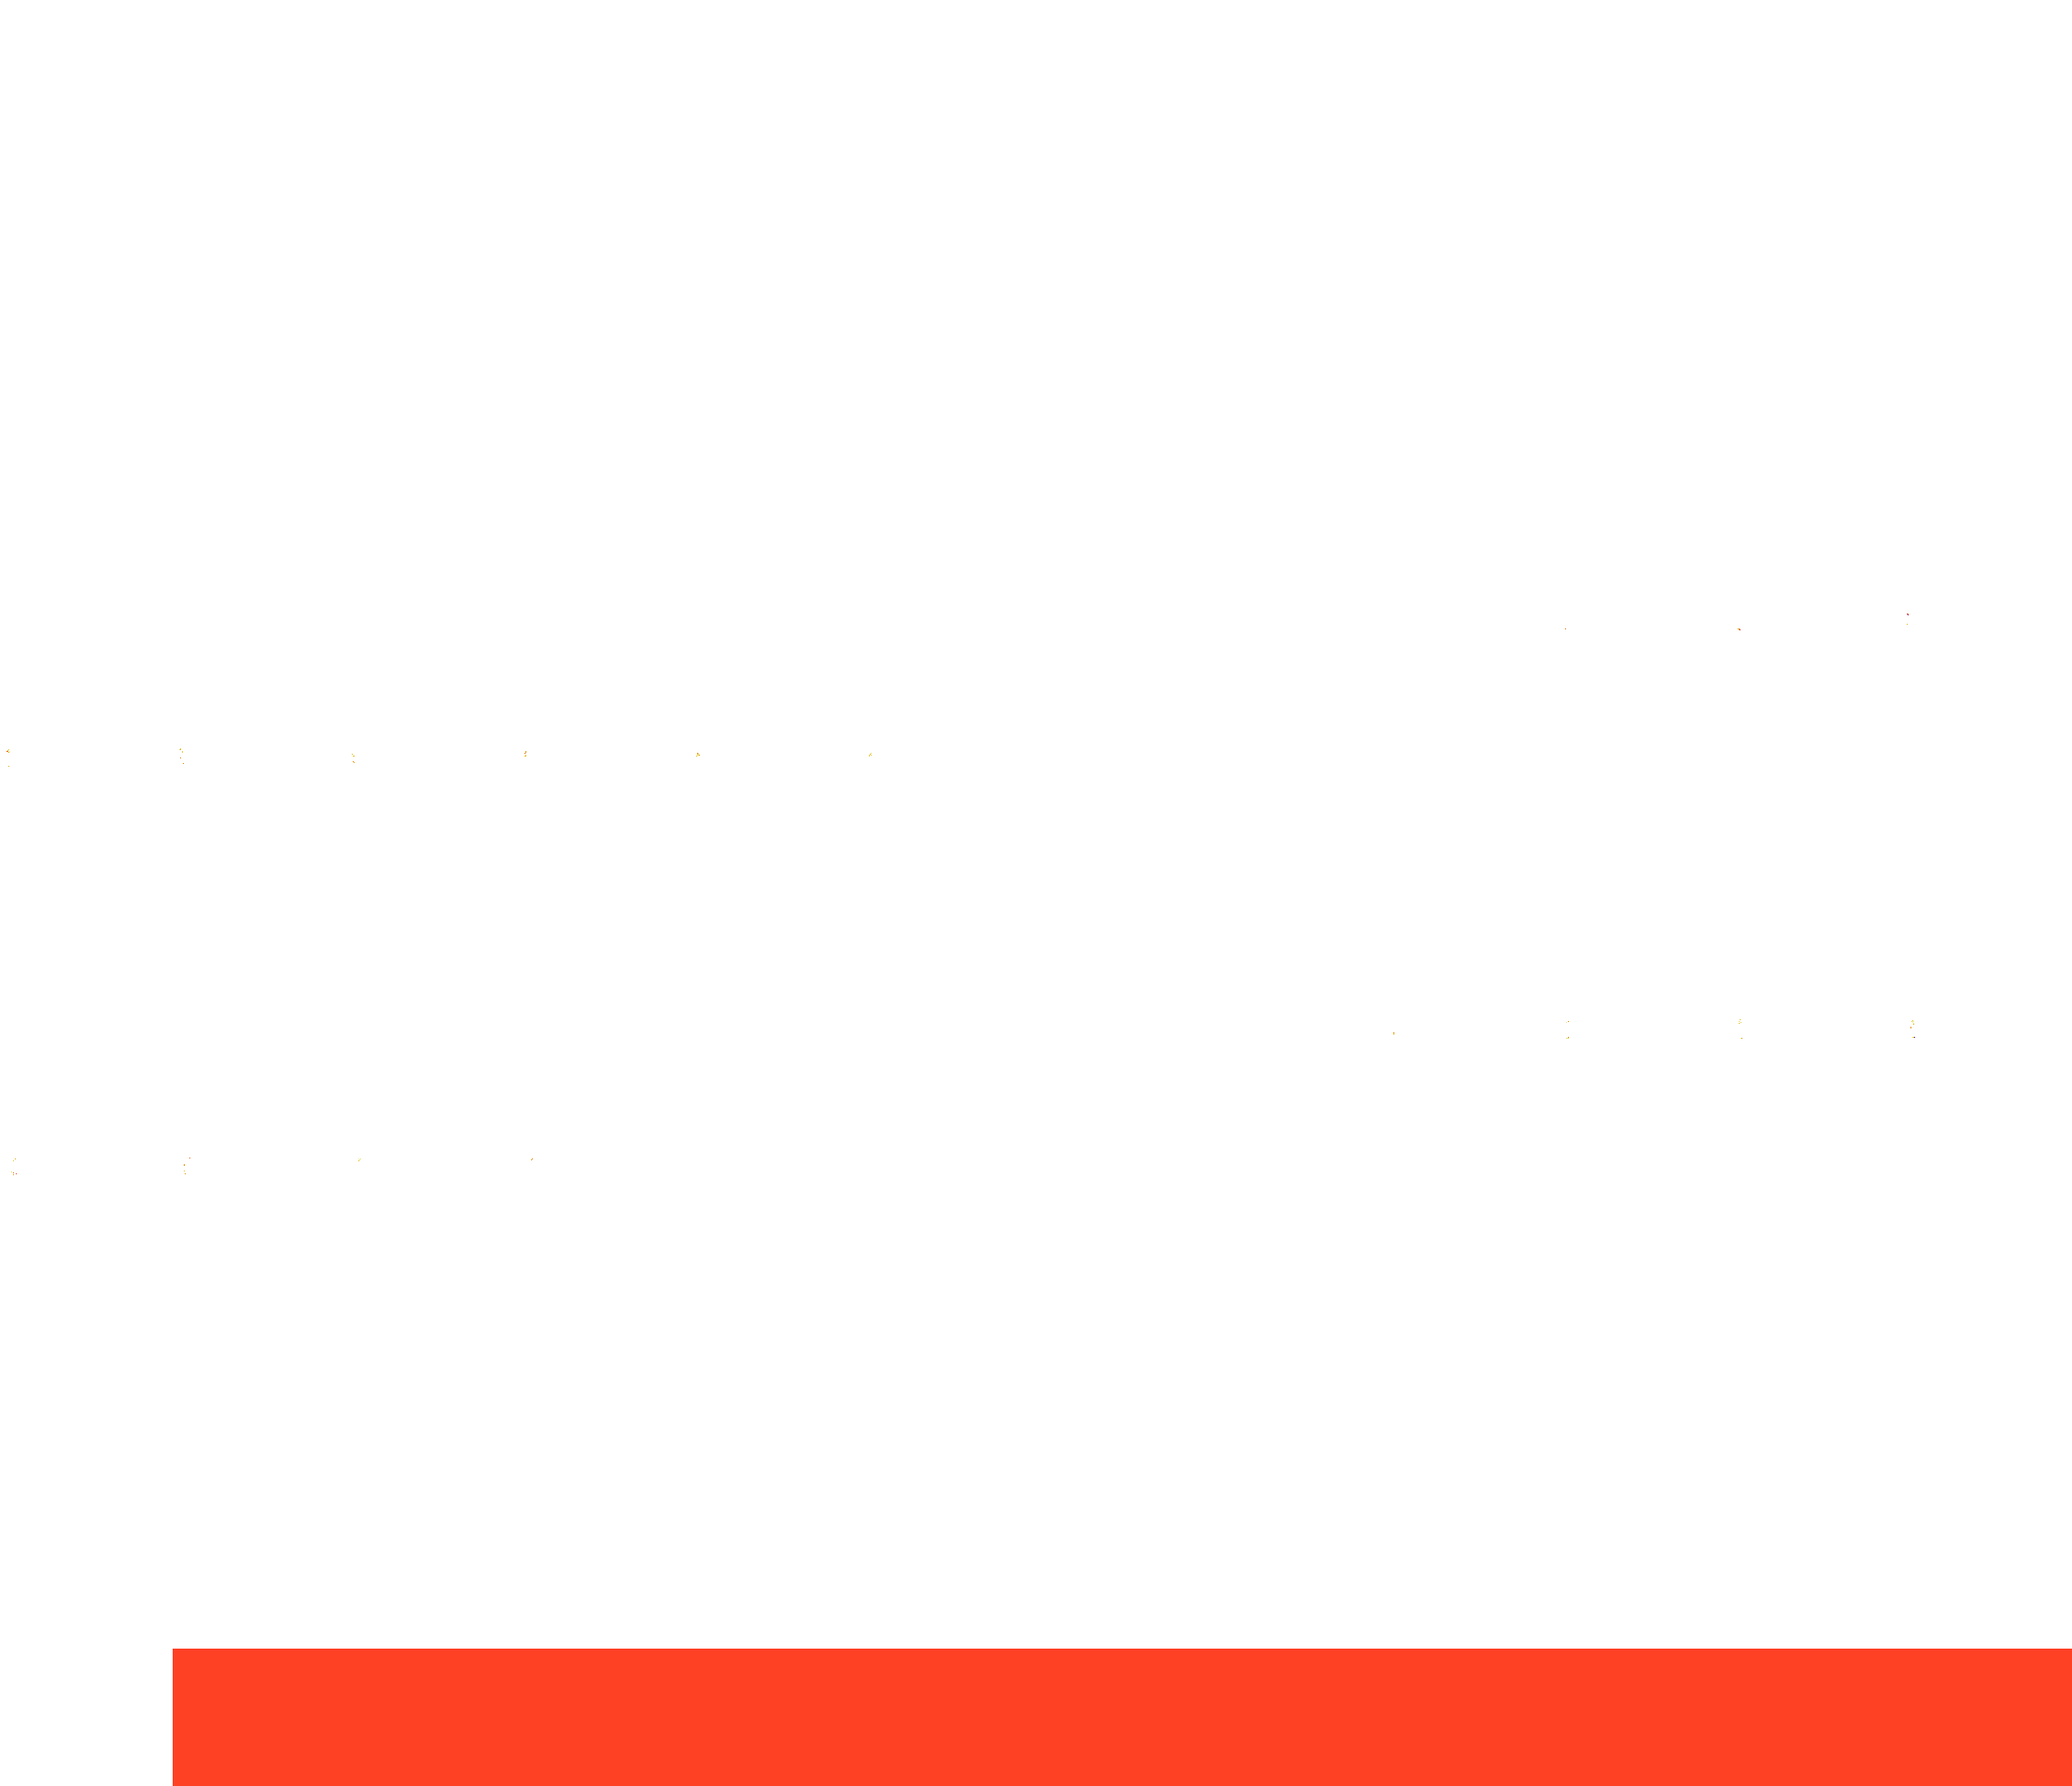

In [59]:
from scipy.special import softmax
anat_sub1_np = NSP.cortex.anat_templates(prf_dict)['subj01'].get_fdata()
# print(anat_maps['subj01'].shape)

anat_sub1_coords = NSP.utils.numpy2coords(anat_sub1_np, keep_vals = True)

anat_sub1_coords[:,3] = softmax(anat_sub1_coords[:,3])

anat_sub1_sm = NSP.utils.coords2numpy(anat_sub1_coords, shape = NSP.cortex.anat_templates(prf_dict)['subj01'].shape, keep_vals = True)

# Convert numpy array back to nibabel image
anat_sub1_sm_nii = nib.Nifti1Image(brain*100, NSP.cortex.anat_templates(prf_dict)['subj01'].affine)

# Now you can use this nibabel image with nilearn's plotting function
# plotting.view_img(anat_sub1_sm_nii, bg_img=None, cmap='binary', symmetric_cmap=False)
plotting.view_img(anat_sub1_sm_nii, bg_img=None, cmap='CMRmap', symmetric_cmap=True)

# plotting.view_img(anat_sub1_sm, bg_img=None, cmap='binary', symmetric_cmap=False)


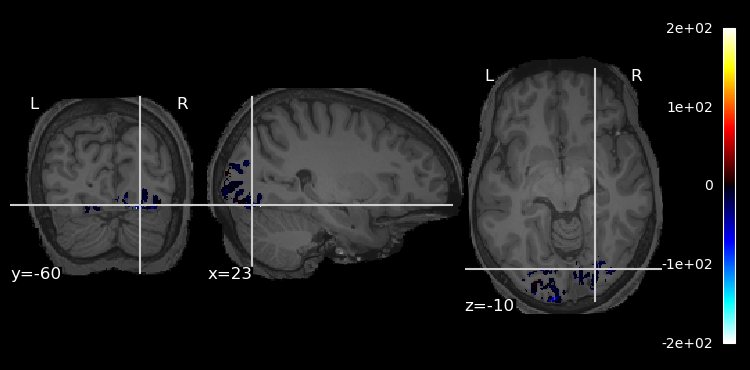

In [208]:
plotting.plot_stat_map(anat_sub1_sm_nii, bg_img=NSP.cortex.anat_templates(prf_dict)['subj01'], display_mode='ortho', colorbar=True)

In [ ]:
# This function creates a numpy array that I can use to transform into a plottable numpy array in the shape of the subjects brain.
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from nilearn import plotting, image
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap


def visualise_betas(hrf_dict = None, subject = 'subj01', n_trials = 10, which_roi = 'V1', n_voxels = 'all', z_voxel:bool = True):
    if which_roi == 'all':
        rois = hrf_dict[subject].keys()
    else: 
        rois = [f'{which_roi}_mask']
    
    for roi in rois:
        if n_voxels == 'all':
            n_voxels = len(hrf_dict[subject][roi])
            
        voxbetas = np.zeros((n_voxels, n_trials + 3))    
        print(voxbetas.shape)
        # Initialize lists to store voxel coordinates and beta values
        voxel_coords = []
        beta_values = []

        for whichvox, voxel in enumerate(list(hrf_dict[subject][roi].keys())[1 : (n_voxels + 1)]): # 1 because the first one is not a voxel but roi_sizes
            betas = hrf_dict[subject][roi][voxel]['hrf_betas'][:n_trials]
            if z_voxel:
                betas = get_zscore(betas, print_ars = False)
            voxel = hrf_dict[subject][roi][voxel]['xyz']
            
            # Append voxel coordinates and beta values to the lists
            voxel_coords.append(voxel)
            beta_values.append(betas)

            voxbetas[whichvox,:3] = voxel
            voxbetas[whichvox,3:] = betas

        
    def _trialbrain(trial_ar=None, which_trial=0, subject = None):
        anat_sub1 = nib.load(f'/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/T1_to_func1mm.nii.gz')

        trial_np = coords2numpy(np.concatenate((voxbeta_df[:,:3], voxbeta_df[:,which_trial:which_trial + 1]), axis=1), shape=prf_dict['subj01']['nsd_dat']['angle']['prf_ar'].shape, keep_vals=True)
        
        trial_nii = nib.Nifti1Image(trial_np, anat_sub1.affine)

        # data = trial_np
        # ref_img = nib.Nifti1Image(np.empty_like(data), affine=np.eye(4))
        # zscored_img = image.new_img_like(ref_img, data)

        # # Define the colors
        # cmap = LinearSegmentedColormap.from_list(
        #     "mycmap", [(0, "black"), (0.5, "blue"), (1, "red")]
        # )
        
        # # Create the TwoSlopeNorm instance with vmin and vmax set during creation
        # norm = TwoSlopeNorm(vcenter=0, vmin=-3, vmax=3)

        # Plot the stat map
        # plotting.plot_stat_map(zscored_img, cmap=cmap, norm=norm, colorbar=True)
        plotting.plot_stat_map(trial_nii, bg_img=anat_sub1, display_mode='ortho', colorbar=True)
        plt.show()

            
    _trialbrain(trial_ar = voxbetas, which_trial = 7, subject = subject) # Doesn't work for a lot of trials, annoying. Fix the colour mapping
                    
                    
    return voxbetas
            
voxbeta_df = visualise_betas(hrf_dict = hrf_dict_tight, subject = 'subj01', n_trials = 30000, which_roi = 'V4', n_voxels = 'all', z_voxel = True)

##### Combine the plotting function below to visualise the R2 nifti I'll make tonight

In [284]:
NSP.cortex.viscortex_plot(prf_dict = prf_dict, vismask_dict = roi_masks, plot_param = 'nsdR2', subject = 'subj01', upcap = 100, lowcap = 0, inv_colour = False, cmap = 'gist_stern')


interactive(children=(IntSlider(value=144, description='x', max=432, min=-144), IntSlider(value=6, description…

Loading the Model...


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time per image: 0.15640521049499512 seconds


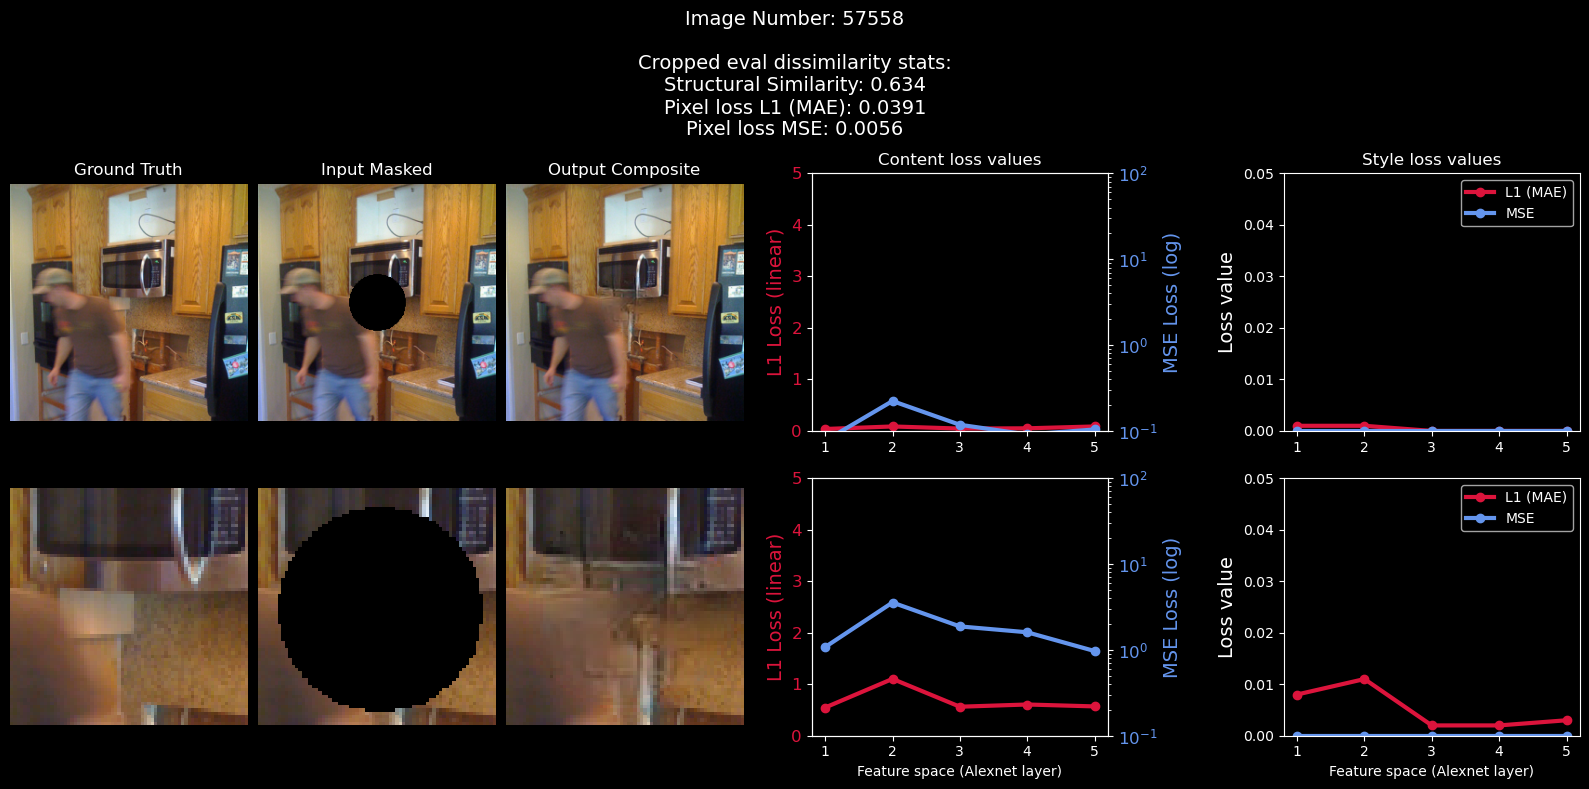

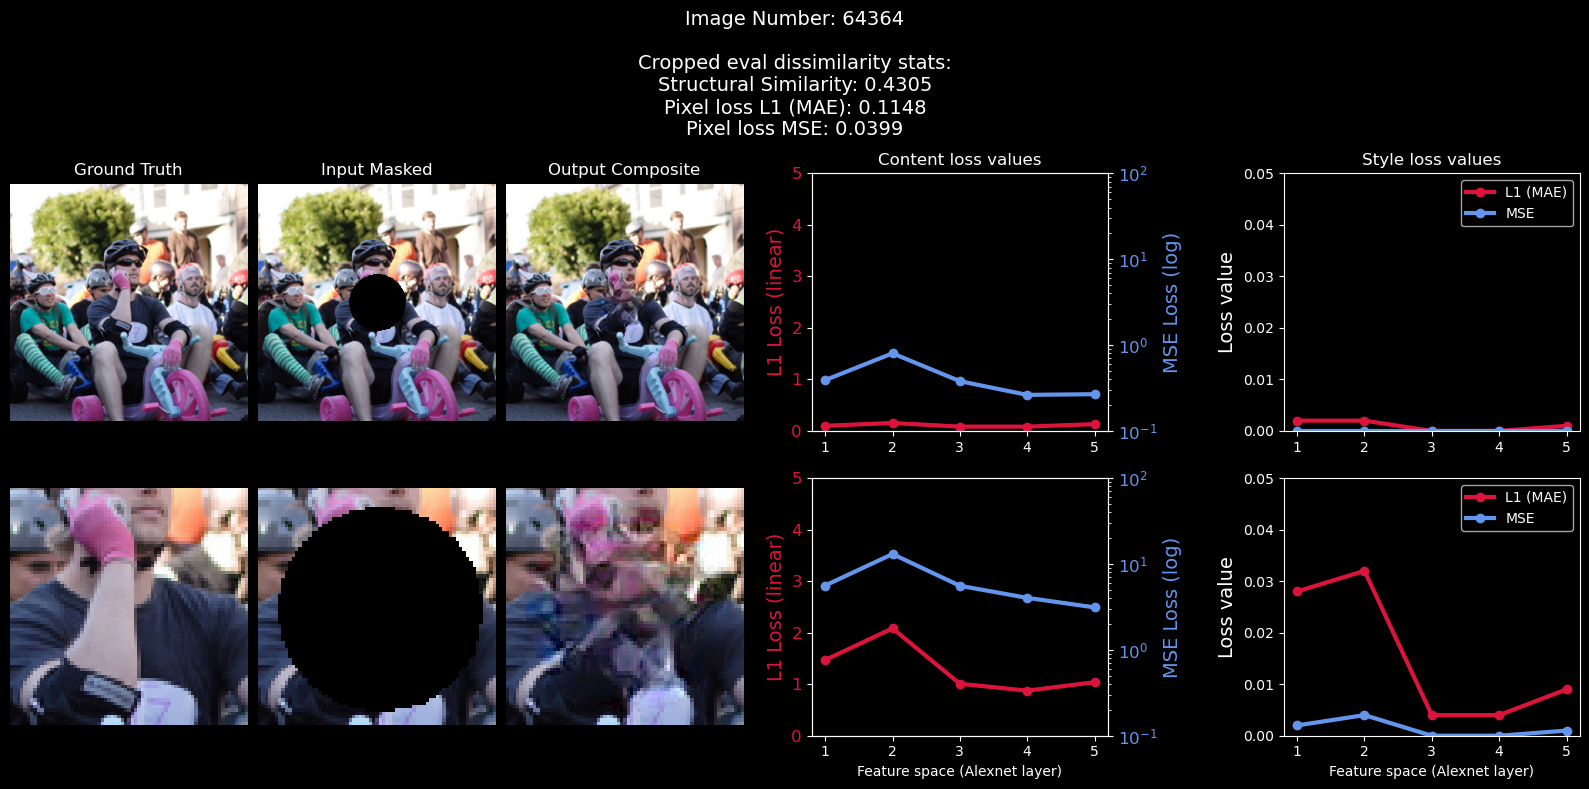

In [13]:
R2_dict = NSP.cortex.nsd_R2_dict(roi_masks, glm_type='hrf')
prf_rsq_dict = NSP.cortex.rsquare_selection(prf_dict, 1000, n_subjects=8, dataset='prf')
nsd_rsq_dict = NSP.cortex.rsquare_selection(R2_dict, 1000, n_subjects=8, dataset='nsd')

Subject: subj01, Voxel 1 out of 10 found
Subject: subj01, Voxel 2 out of 10 found
Subject: subj01, Voxel 3 out of 10 found
Subject: subj01, Voxel 4 out of 10 found
Subject: subj01, Voxel 5 out of 10 found
Subject: subj01, Voxel 6 out of 10 found
Subject: subj01, Voxel 7 out of 10 found
Subject: subj01, Voxel 8 out of 10 found
Subject: subj01, Voxel 9 out of 10 found
Subject: subj01, Voxel 10 out of 10 found


Currently 10 prfs found
Subject: subj02, Voxel 1 out of 10 found
Subject: subj02, Voxel 2 out of 10 found
Subject: subj02, Voxel 3 out of 10 found
Subject: subj02, Voxel 4 out of 10 found
Subject: subj02, Voxel 5 out of 10 found
Subject: subj02, Voxel 6 out of 10 found
Subject: subj02, Voxel 7 out of 10 found
Subject: subj02, Voxel 8 out of 10 found
Subject: subj02, Voxel 9 out of 10 found
Subject: subj02, Voxel 10 out of 10 found


Currently 20 prfs found
Subject: subj03, Voxel 1 out of 10 found
Subject: subj03, Voxel 2 out of 10 found
Subject: subj03, Voxel 3 out of 10 found
Sub

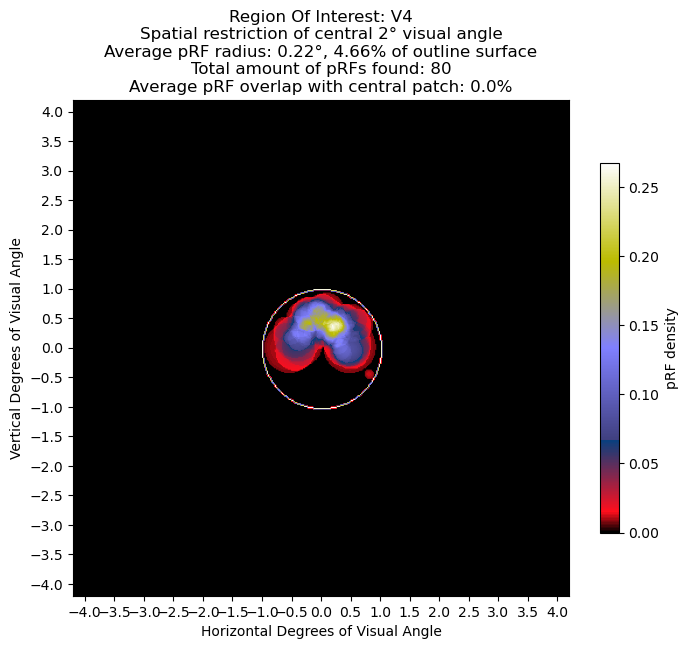

Runtime: 124.022 seconds
There were <built-in function iter> out of 3976 pRFs considered


In [18]:

start = time.time()
# heatmap, iter, end_premat, roi, prf_sizes, avg_surf, total_prfs, prfmask_dict, prf_overlaps
end_premat = NSP.cortex.prf_heatmap(10, binary_masks=roi_masks, prf_proc_dict=prf_dict,
                                                        mask_type='cut_gaussian', cmap='gist_stern', print_prog='y', 
                                                        roi='V4', sigma_min=0, sigma_max = 1, ecc_max = 1, subjects='all', 
                                                        outline_degs = 1, 
                                                        filter_dict = nsd_rsq_dict, ecc_strict = 'y')[2]

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

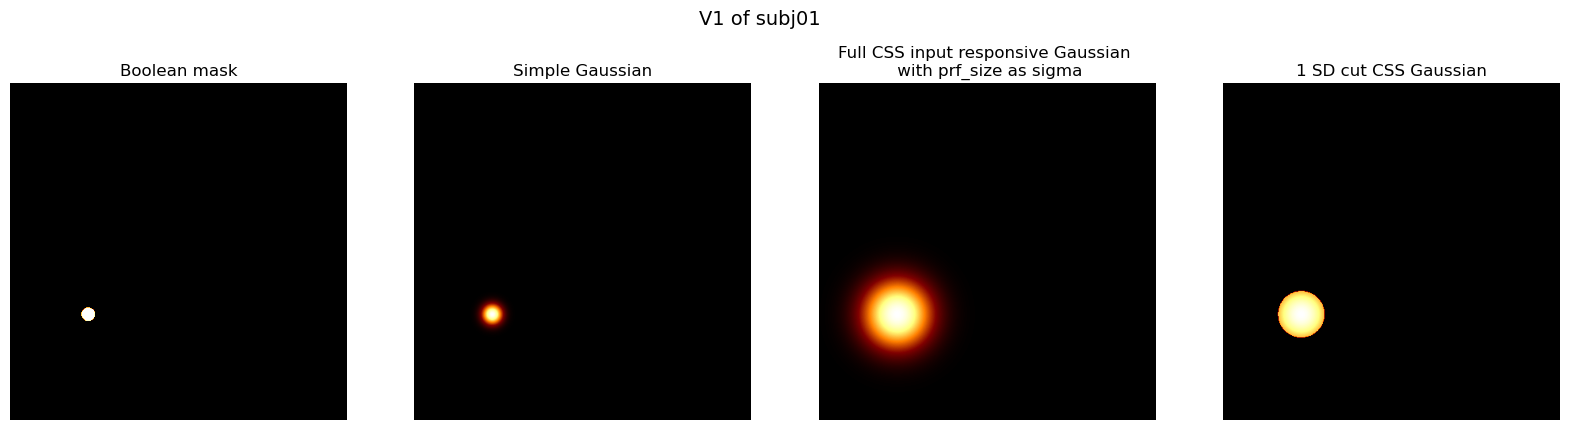

In [65]:
NSP.explore.compare_masks(roi_masks, prf_dict)

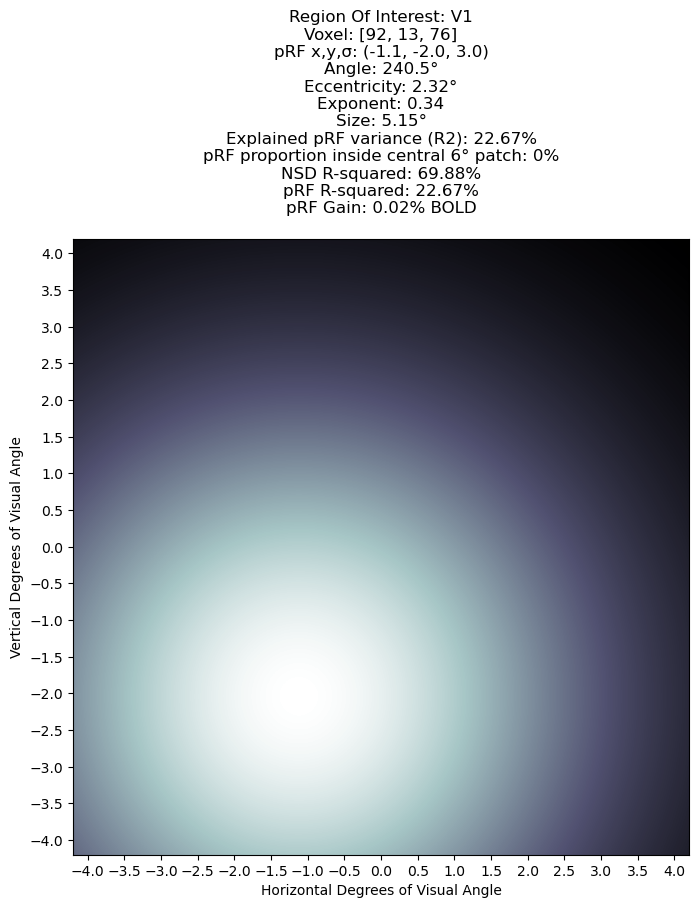

In [47]:
out = NSP.cortex.get_mask(dim = 425, subject = 'subj01', binary_masks = roi_masks, 
                                        prf_proc_dict = prf_dict, type='gaussian', roi='V1',
                                        plot = 'y', excl_reason = 'n', sigma_min=2.9, sigma_max = 3,
                                        ecc_min = 2, ecc_max = 3,
                                        angle_min = 0, angle_max = 360)

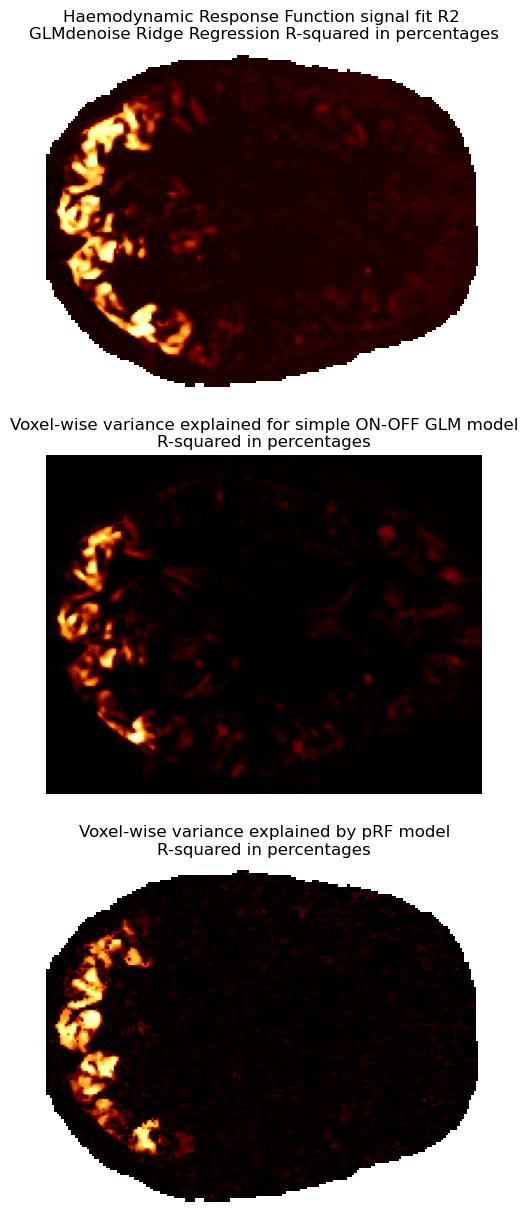

In [44]:
NSP.explore.compare_NSD_R2s(roi_masks, prf_dict, 'subj01', 76)

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['input', 'Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2', 'Conv2d_3', 'ReLU_3', 'Conv2d_4', 'ReLU_4', 'Conv2d_5', 'ReLU_5', 'MaxPool2d_3', 'Dropout_1', 'Linear_1', 'ReLU_6', 'Dropout_2', 'Linear_2', 'ReLU_7', 'Linear_3']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


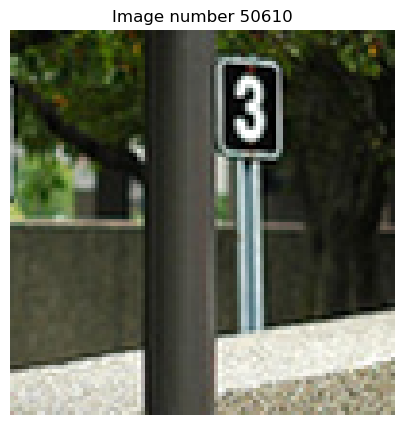

In [17]:
_ = NSP.stimuli.show_stim(img_no=img_ids[0], small=True, crop=True)

ReLU_5


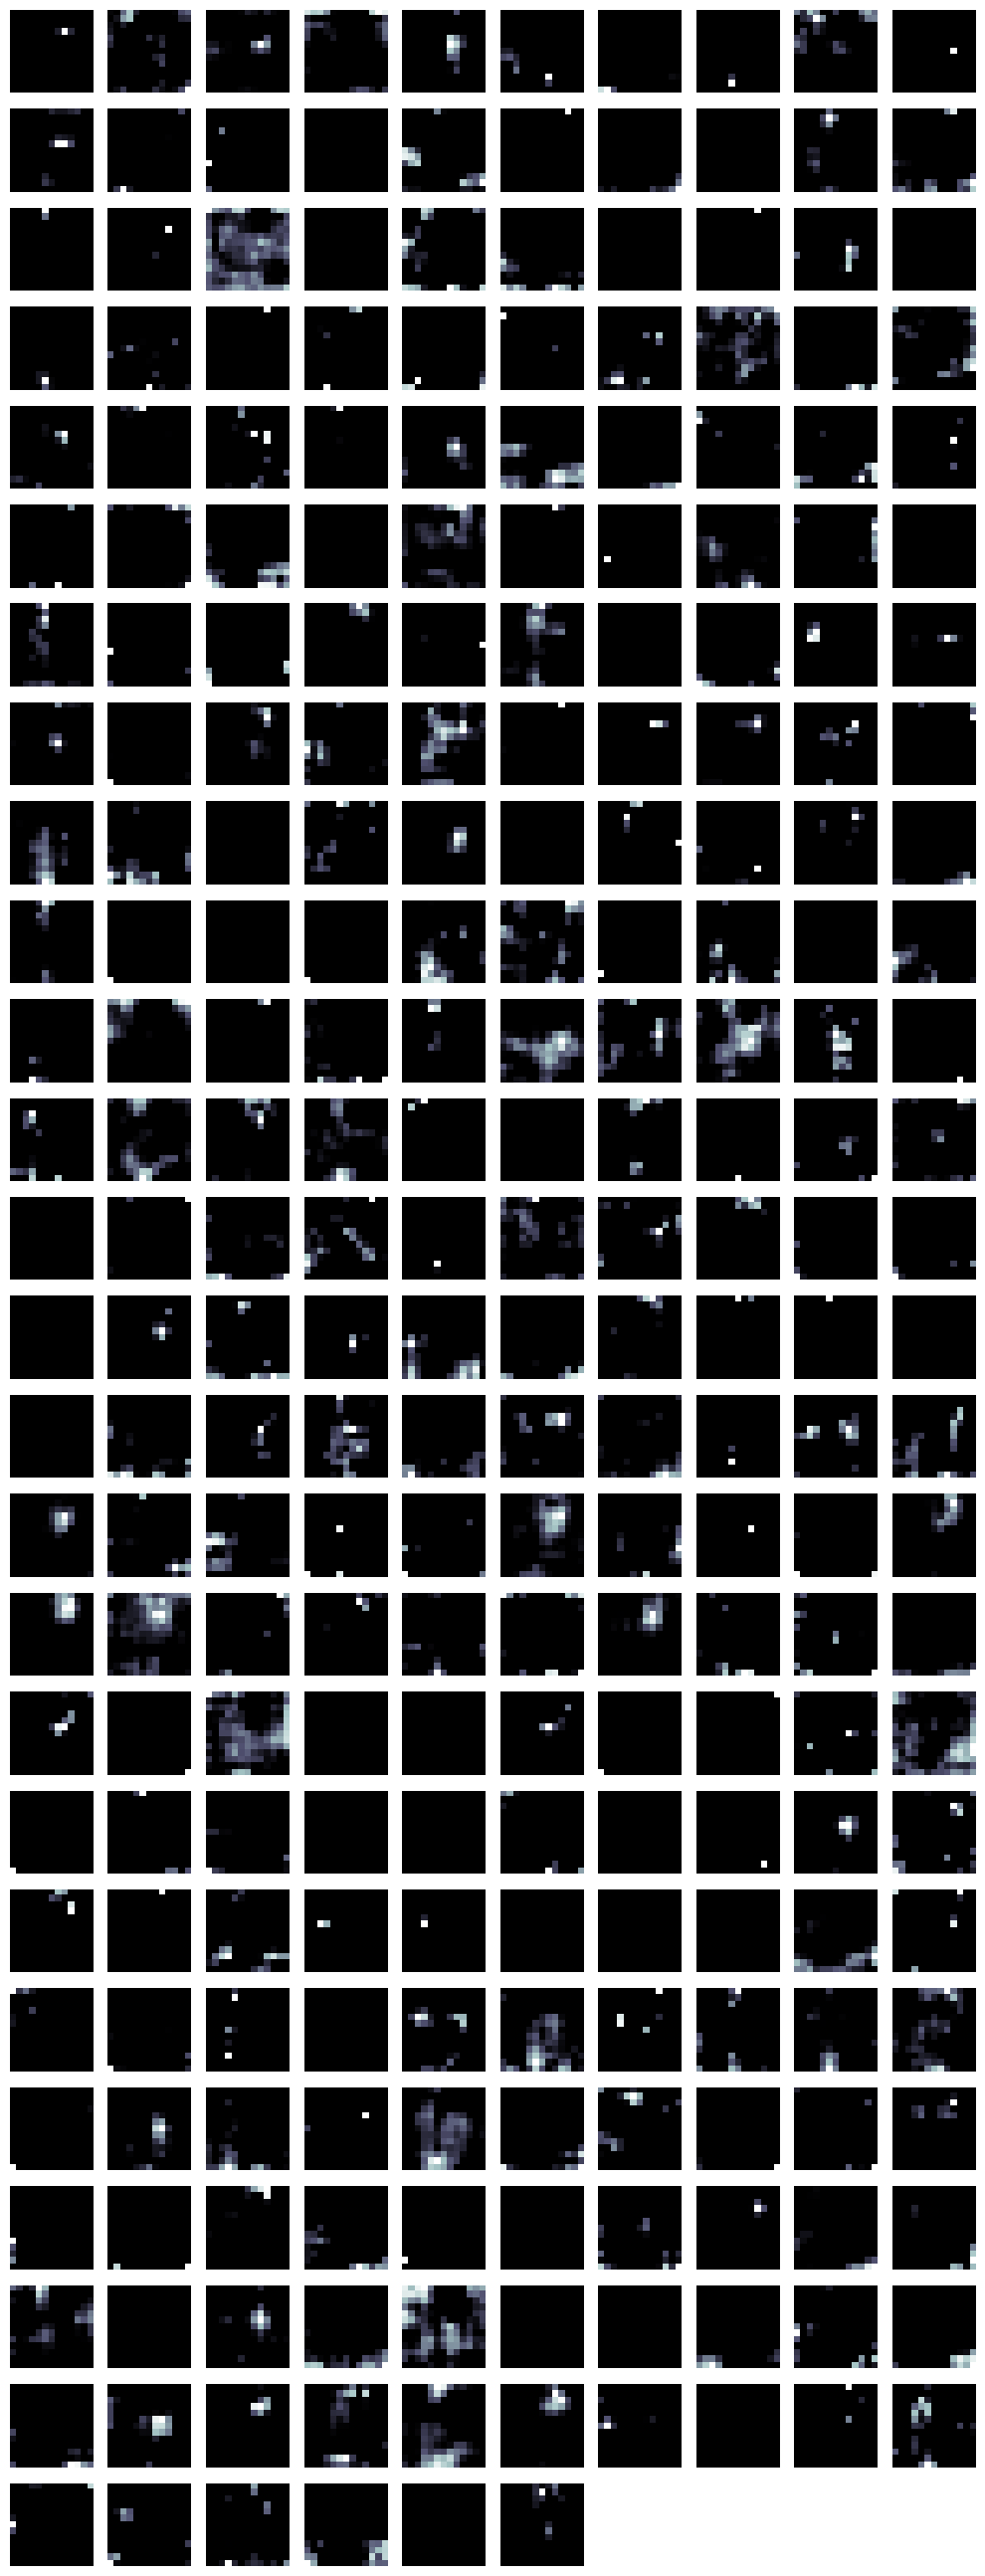

In [35]:
# rois, roi_masks = NSP.visrois_dict()
# prf_dict = NSP.prf_dict(rois, roi_masks)

anats = NSP.anat_templates(prf_dict)

In [37]:
del rois, roi_masks, prf_dict, anats

In [46]:
import psutil
import os
# del NSP
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2} MB")

print_memory_usage()

Memory usage: 2329.828125 MB


In [11]:
def print_user_variables():
    print("\n".join("%s: %s" % item for item in globals().items() if not item[0].startswith("__")))

print_user_variables()

_ih: ['', 'class DataFetch():\n    \n    def __init__(self):\n        pass\n    # Function to get the visual contrast features and predictability estimates\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def features(self):\n        feature_paths = [\n            \'./data/custom_files/all_visfeats_rms.pkl\',\n            \'./data/custom_files/all_visfeats_rms_crop_prior.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl\',\n            \'/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5\'\n        ]\n        return {os.path.basename(file): self._fetch_file(file) for file in feature_paths}\n    # Function to get the pRF-based voxel selections\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def prf_selections(self):\n        prf_selection_paths = [\n    

In [42]:
import psutil
import os

def print_cpu_usage():
    process = psutil.Process(os.getpid())
    print(f"CPU usage: {process.cpu_percent()}%")

print_cpu_usage()

CPU usage: 0.0%


In [32]:
import sys

x = "Hello, world!"
print(f"Memory usage of x: {sys.getsizeof(heatmap)} bytes")

def inbytes(x):
    return sys.getsizeof(x)


Memory usage of x: 1445128 bytes


180625

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# AlexNet(
#   (features): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#     (1): ReLU(inplace=True)
#     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#     (4): ReLU(inplace=True)
#     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (7): ReLU(inplace=True)
#     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (9): ReLU(inplace=True)
#     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (11): ReLU(inplace=True)
#     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
#   (classifier): Sequential(
#     (0): Dropout(p=0.5, inplace=False)
#     (1): Linear(in_features=9216, out_features=4096, bias=True)
#     (2): ReLU(inplace=True)
#     (3): Dropout(p=0.5, inplace=False)
#     (4): Linear(in_features=4096, out_features=4096, bias=True)
#     (5): ReLU(inplace=True)
#     (6): Linear(in_features=4096, out_features=1000, bias=True)
#   )
# )